# Microbe v. Commensal Models:
### Integrating Host Response and Unbiased Microbe Detection for Lower Respiratory Tract Infection Diagnosis in Critically Ill Adults
Katrina Kalantar

Developed through May 2018, finalized September 2018

Analysis for pathogen v. commensal model portion of the mini-BAL study.

# Set-up

## Environment Setup

In [1]:
# set the width of the jupyter notebook so we don't waste so much valuable browser real-estate!
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# required libraries
from collections import Counter
import csv
import glob
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from pylab import *
import random
import seaborn as sns
import sklearn
import statistics
import scipy
import scipy.stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_curve
import sys, os.path
import warnings; warnings.simplefilter('ignore')

# import microbial analysis and plotting functions 
# developed by me, but moved to external scripts for simplicity in .ipynb
scripts_dir = './scripts/'
sys.path.append(scripts_dir)
import pathogen_functions 
import plotting_functions

#https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('fivethirtyeight')   
%matplotlib inline  

## Import Data

### Curated List of Top Respiratory Pathogens (and viruses)
Manually currated from literature search, clinician input, and the NCBI taxonomy database

The **list_of_viruses_in_dictionary** contains all microbes which are listed as "Viruses". The **full_respiratory_microbes_list** contains all microbes identified as "likely pathogenic" in the respiratory tract.

In [3]:
v = open('./reference/viruses.txt', 'r').readlines()                             # a priori curated list of all viruses
list_of_viruses_in_dictionary = [i.strip() for i in v]
resp_mic = open('./reference/known_respiratory_pathogens.txt', 'r').readlines()  # a priori curated list of top respiratory pathogens
full_respiratory_microbes_list = [i.strip() for i in resp_mic]

### Global Variables

In [4]:
data_directory =  '042018'
output_directory = '091318'
topX = 15 # because all microbes identified in culture are present among the top 15 microbes

# read in metadata to get RNA and DNA file names
metadata = pd.read_csv(
    './data/' + data_directory +
    '/NEB-TA-ONLY-metadata-03.29.18withFilenames.KKadaptation_v3.csv',
    header=0,
    index_col=0)

# remove rows with null DNA filenames; some samples were missing DNA-seq data
metadata = metadata[metadata['DNAfilename']
                    .notnull()]  

# remove rows with null RNA filenames; no RNA-seq files should be missing
metadata = metadata[metadata['RNAfilename']
                    .notnull()] 

# create the "true_classification" variable from the metadata 
a = metadata[['DNAfilename','effective_group','organism']]
b = metadata[['RNAfilename','effective_group','organism']]
b.columns = ['DNAfilename','effective_group','organism']
c = pd.concat([a,b])
c.index = c['DNAfilename']
c.sort_values(by='DNAfilename',inplace=True)
c = c[c['DNAfilename'] != 'n/a']
c = c[['effective_group','organism']]
true_classification = c

file_pairs_dict = dict(
    zip(metadata['DNAfilename'], metadata['RNAfilename']
        ))  #create dictionary mapping RNAfilename with associated DNAfilename

# create a reverse dictionary for file look-up from RNA:DNA later on
file_pairs_dict
file_pairs_dict_rev = {}
for i in file_pairs_dict.keys():
    file_pairs_dict_rev[file_pairs_dict[i]] = i

# these sample names were identified by random selection of host RNA-seq data based on RNA-seq batches.
training_sample_names = ["mBAL-212-RNA-TA1-B10.report.csv","mBAL-225-RNA-TA1-B10.report.csv",
                         "mBAL-298-RNA-TA1-B10.report.csv","mBAL-304-RNA-TA1-B10.report.csv",
                         "mBAL-314-RNA-TA1-B10.report.csv","mBAL-315-RNA-TA1-B10.report.csv",
                         "mBAL-335-RNA-TA1-B10.report.csv","mBAL-337-RNA-TA1-B10.report.csv",
                         "mBAL-343-RNA-TA1-B10.report.csv","mBAL-350-RNA-TA1-B10.report.csv",
                         "mBAL-349-RNA-TA1-B10.report.csv","mBAL-273-RNA-TA1-B10.report.csv",
                         "mBAL-331-RNA-TA1-B10.report.csv","mBAL-221-RNA-TA1-B10.report.csv",
                         "mBAL-220-RNA-TA1-B10.report.csv","mBAL-215-RNA-TA1-B10.report.csv",
                         "mBAL-270-RNA-TA1-B10.report.csv","mBAL-241-RNA-TA1-B10.report.csv",
                         "mBAL-211-RNA-TA1-B10.report.csv","mBAL-218-RNA-TA1-B10.report.csv"]

In [5]:
# write the microbes used for this particular analysis to the output directory
open('./output/' + output_directory + '/USED.viruses.txt', 'w').write(
    '\n'.join(list_of_viruses_in_dictionary));
open('./output/' + output_directory + '/USED.known_respiratory_pathogens.txt',
     'w').write('\n'.join(full_respiratory_microbes_list));

# Run Analysis

Run the main functions to generate scores required for all further plotting steps.

In [6]:
# create the output file that will containg the top 20 microbes for each sample 
# with the caveat that all microbes must be present on both RNA-seq and 
# DNA-seq (with the exception of RNA viruses)
f = open('./output/' + output_directory + '/TableS4.csv', 'w')
f.close()

# run the main function to load microbial data into the data structure for downstream analysis
bacterial, viral, full = pathogen_functions.main('data/' + data_directory + '/BM_4WC_combo',
                                      file_pairs_dict, output_directory,
                                      metadata) 

list_of_files = list( bacterial.keys() )  # create list of RNA files for accessing the outputs

# Pathogen v. Commensal Models

> "Asymptomatic  carriage  of  potentially  pathogenic  organisms  is  common (27, 28), and  only  in  a subset  of cases do  these microbes overtake airway microbial  communities  andprecipitate LRTI (29). As such, distinguishing legitimate pathogens from commensal or colonizing microbiota is  a  central challenge for LRTI diagnostics and  adds  complexity  to  the  interpretation  of metagenomic sequencing data."


### Plotting the RNA rM v. DNA rM for each individual

This also sets up the data for further analysis of microbes and sensitivity / specificity analysis.

The following code gets the RNA / DNA ratio and plots the ratio as a function of group (Group 1 v 4). Here, "Group 2" is actually just a separation of group 1 when the microbe is not identified in culture.

In [7]:
# re-order the list of filenames so that the output sample x sample results are in order of
# Group 1 Train / Group 1 Test / Group 2 / Group 3 / Group 4 Train / Group 4 Test
# note: this ordering is purely for visual effect and interpretability

ordered_list_of_files = []

train_test_split = ['train','test']
for TC in [1, 2, 3, 4]:
    for t in train_test_split:
        if t == 'train':
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[-3]
                metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' in training_sample_names:
                    ordered_list_of_files.append(i)
        else:
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[-3]
                metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' not in training_sample_names:
                    ordered_list_of_files.append(i)

Loop through all pairs of DNA/RNA-seq microbe counts and obtain the metrics required for downstream rules-based and logistic regression model fitting. Simultaneously plot the log(RNA rpM) x log(DNA rpM) for quick visualization of all microbes.

continuing
could not append DNA % in top 15


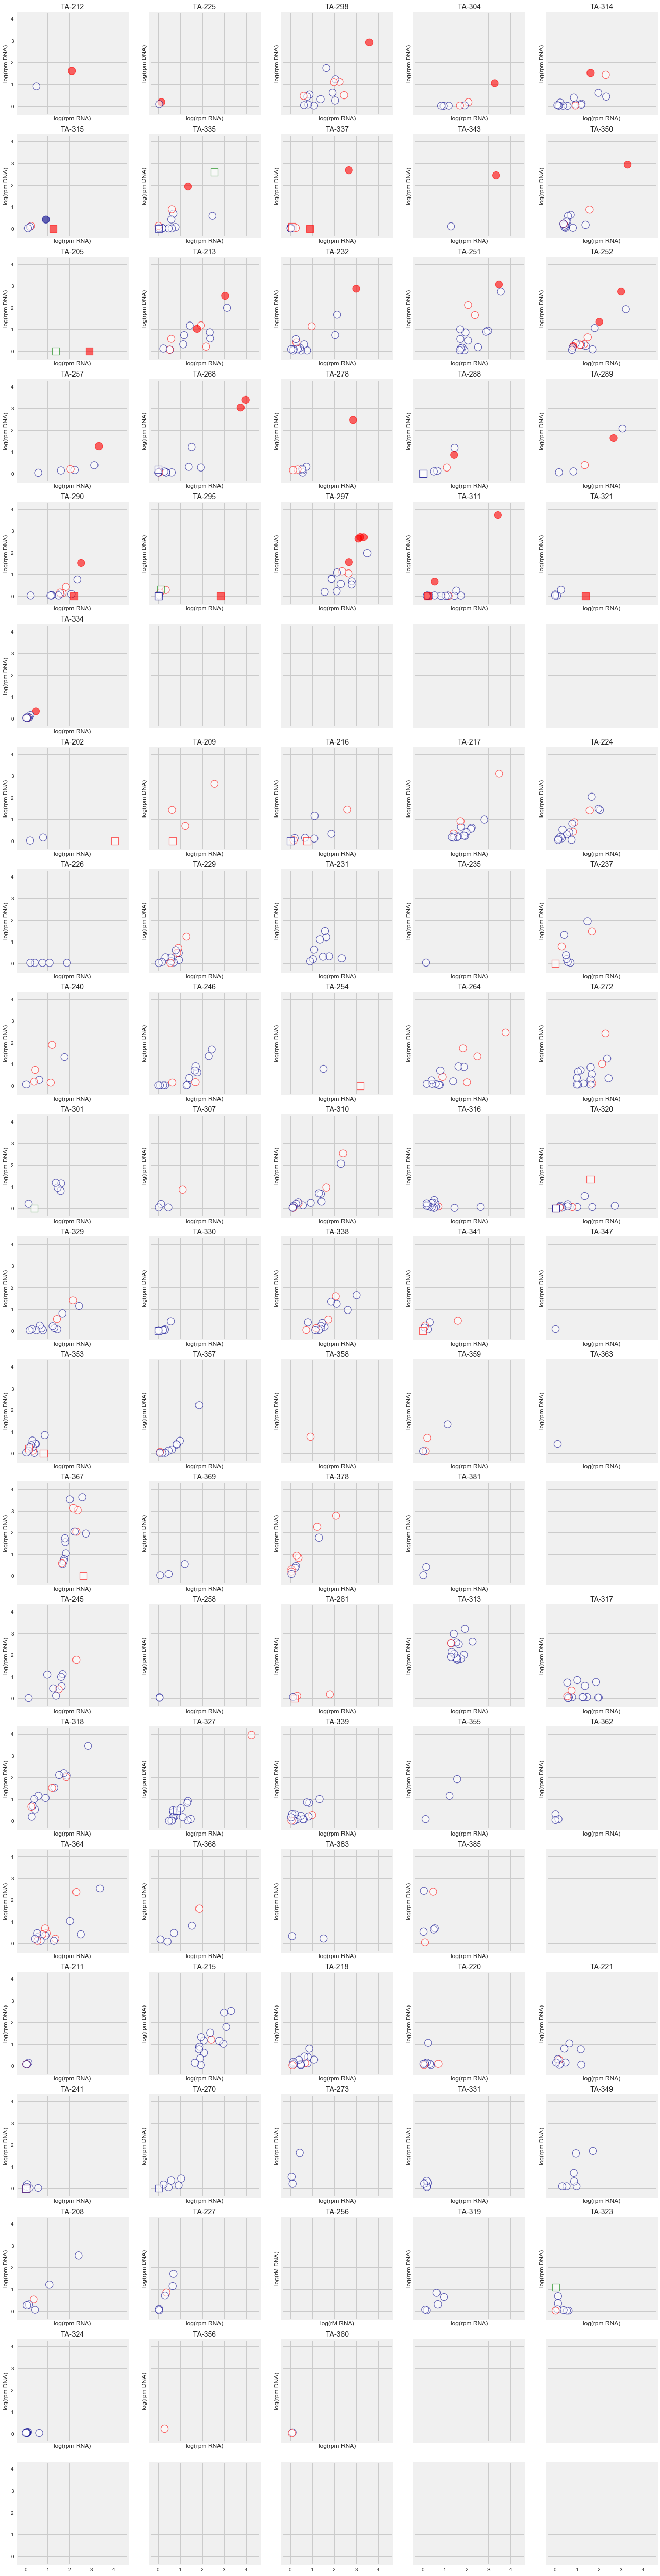

In [8]:
final_results = {}
top_microbes_file = open('./output/' + output_directory + '/top_microbes_by_patient.txt','w')

percent_represented_in_topX_RNA = []
percent_represented_in_topX_DNA = []

RNA_value = []
DNA_value = []
positive = []
pathogenic = []
virus = []
nrnt_model = []
groupid = []
microbe_id = []
microbe_id_genus = []
patient_id = []
ranks = []
nt_genusz_dna = []
nt_genusz_rna = []

RNA_value_test = []
DNA_value_test = []
positive_test = []
pathogenic_test = []
virus_test = []
nrnt_model_test = []
test_files = []

sensitivity_analysis_results = {}

cultured_fill = ['white']
cultured_colors = ['blue','red']

fig, axarr = plt.subplots(21,5, figsize=(20, 92), sharex=True, sharey=True, facecolor='white')

row = 0
col = 0

f = open('./output/' + output_directory + '/raw_data_pathogen_scoring.txt','w')
do_not_continue = False
ranks_from_culture = {}

list_of_files = list(bacterial.keys())
prev_sample_tc = 0

for i in ordered_list_of_files:   # loop through all files

    sample_id = i.split('/')[-1].split('.')[-3]
    metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]   
    
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]   # set group ID
    ranks_from_culture[i] = []

    if tc == 1 or tc == 4 or tc ==3 or tc ==2:

        if(not do_not_continue):
            
            # this modifies the scatterplot point shape based on the group, 
            # currently setting all to circles
            group = 'o'  
            
            # in the plot of log(RNA rpM) x log(DNA rpM) we want to divide into sections based 
            # on sample adjuciation - all samples from Group 1 are grouped together, followed by 
            # all samples in G2, etc. This section creates a new line whenever the group switches.
            if tc == 1 and prev_sample_tc < tc:
                print('continuing')
            if tc == 2 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 3 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 4 and prev_sample_tc < tc:
                row +=1 
                col = 0

            bac = full[i]   # current data to be plotted on this iteration

            if(bac.shape[0] > 0):
                bac = bac.reset_index()
                
                # sort the operating matrix by column RPM
                bac.sort_values(by='NT Genus rM RNA', inplace=True, ascending=False)   
                bac = bac.reset_index() #reindex([i for i in range(len(bac.index))])
                
                # Keep track of the percent of all microbial rpM that are represented in the 
                # top 15 microbes. This threshold was selected based on the fact that all 
                # culture-identified microbes were present w/in the top 15. Here we quantify
                # the total % microbial represnted by this subset.
                try:
                    percent_represented_in_topX_DNA.append(bac.head(n=topX)['NT Genus rM DNA']
                                                           .sum()/bac['NT Genus rM DNA'].sum())
                except:
                    print("could not append DNA % in top 15")
                try:
                    percent_represented_in_topX_RNA.append(bac.head(n=topX)['NT Genus rM RNA']
                                                           .sum()/bac['NT Genus rM RNA'].sum())
                except:
                    print("could not append RNA % in top 15")
                
                # topX allows us to select the top N microbes (15 for the purpose of the study)
                bac = bac.head(n=topX) 
                bac['NT Genus rM DNA scaled'] = (bac['NT Genus rM DNA']
                                                 /bac['NT Genus rM DNA'].sum())
                bac['NT Genus rM RNA scaled'] = (bac['NT Genus rM RNA']
                                                 /bac['NT Genus rM RNA'].sum())              
                bac.fillna(0)
                
                # this outputs the full topX microbes (DNA and RNA data) to .txt file .
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                top_microbes_file.write("\n----\n" + i + "\n\n")
                top_microbes_file.close()
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                bac.to_csv('./output/' + output_directory + 
                           '/top_microbes_by_patient.txt', sep='\t', mode='a')
                top_microbes_file.write("\n\n")
                top_microbes_file.close()
                
                grew_in_culture = []   # fill color
                is_pathogen = []       # edge color
                is_virus = []          # shape (square = virus, circle = bacteria/fungi)
                nrnt_pointsize = []    # NO LONGER APPLICABLE

                bac = bac.dropna(axis=0, how='all')

                rank_number_identified = 0
                for n in bac.index:
                    rank_number_identified += 1   # increment with each microbe
                    
                    # implementing a heuristic for assigning most likely 
                    # species to genus-level rpM
                    curr_genus = bac.loc[n]['Species_x']    # default is DNA species...
                    species_colID = 'Species_x'
                    
                    # ...but if RNA rM is greater, then set curr_genus to the RNA species
                    if bac.loc[n]['NT Genus rM DNA'] < bac.loc[n]['NT Genus rM RNA']:   
                        curr_genus = bac.loc[n]['Species_y']
                        species_colID = 'Species_y'

                    # TODO: Could remove this section - 
                    # no longer looking at NR:NT ratio for this paper
                    if(True):
                        # get the genus to use as a tag for finding the concordance
                        g = ' '.join(bac.loc[n]['Genus'].split(' ')[0:-3])   
                        try:
                            # try to append the NRNT point size
                            nrnt_pointsize.append(float(nrnt_values.loc[g]['prop'])) 
                            print("WEIRD...NRNT WAS FOUND: " + str(g))
                        except:   # if the NRNT value can't be found, just append zero...
                            # ...  cases in which it can't be found are when rM is extremely low
                            nrnt_pointsize.append(1)  #NO NRNT POINT SIZE

                    #
                    # set the facecolor of points based on classificaiton of microbe. Overall... 
                    # blue = non-pathogenic bacteria/fungi
                    # green = non-pathogenic virus
                    # red = pathogenic (bacteria, virus, or fungi)
                    #
                    
                    set_color = "darkblue"     # default blue
                    if (curr_genus in list_of_viruses_in_dictionary):  #if genus is any virus, green
                        set_color = "green"
                        is_virus.append("green")   
                    else:
                        is_virus.append('none')
                    # set red if pathogen, regardless of whether it was previously 
                    # set to green for "virus"; this means that viruses on list of pathogens
                    # will appear red, not green.
                    if (' '.join(curr_genus.split(' ')[0:2]) in full_respiratory_microbes_list) or (
                        curr_genus.split(' ')[0] in full_respiratory_microbes_list) or (
                        curr_genus in full_respiratory_microbes_list):  
                        set_color = "red"
                    
                    # to the vector of pathogenicity, append the color; red == pathogen
                    is_pathogen.append(set_color)  

                    
                    #
                    # set the fill color based on whether the microbe grew in culture
                    # colors are consistent with the outline colors when grew_in_culture is true,
                    # otherwise fill color is empty
                    # 
                    
                    if (tc == 1 or tc==2) and not (isinstance((metadata.loc[metadata_id]['organism']), float)): # this grew in culture
                        if bac.loc[n]['Genus'] in list(metadata.loc[metadata_id]['organism'].split(',')):      
                            ranks_from_culture[i].append(rank_number_identified)
                            grew_in_culture.append(set_color) 
                        else:
                            grew_in_culture.append('white')     # this did not grow in culture
                    else:
                        # this was not in G1 or G2, therefore did not grow in culture 
                        grew_in_culture.append('white')    
                        
                    g = bac.loc[n]['Genus']   # genus-level microbe ID
                    

                #
                # make plot of all microbes, split by individuals, weighted by nrnt concordance 
                #
        
                # this defines the plot structure - 5 columns, up to 21 rows 
                # (bc we have 100 samples)
                if row < 21 and col < 5: 
                
                    correct_species_names = []
                
                    # plot viruses a different shape
                    bac['is_pathogen'] = is_pathogen
                    bac['grew_in_culture'] = grew_in_culture
                    bac['nrnt_pointsize'] = nrnt_pointsize
                    bacv = bac[bac['Category']=="Viruses"] 
                    baco = bac[bac['Category']!="Viruses"] 
                    axarr[row,col].scatter(np.log10((baco['NT Genus rM RNA']+1)),  
                           np.log10((baco['NT Genus rM DNA']+1)),
                           alpha = .6, edgecolor=baco['is_pathogen'], 
                           facecolor = baco['grew_in_culture'], 
                           marker='o', s =[max(j*200,20) for j in baco['nrnt_pointsize']], 
                           linewidth=1.2 )
                    axarr[row,col].scatter(np.log10((bacv['NT Genus rM RNA']+1)),  
                           np.log10((bacv['NT Genus rM DNA']+1)),
                           alpha = .6, edgecolor=bacv['is_pathogen'], 
                           facecolor = bacv['grew_in_culture'], 
                           marker='s', s =[max(j*200,20) for j in bacv['nrnt_pointsize']], 
                           linewidth=1.2 )
                    
                    
                    # loop through microbes and annotate the scatterplot with text 
                    for n in bac.index:
                        curr_genus = bac.loc[n]['Species_x']    # default is DNA species...
                        species_colID = 'Species_x'
                        # ... but if RNA rM is greater, then curr_genus is the rna genus
                        if bac.loc[n]['NT Genus rM DNA'] < bac.loc[n]['NT Genus rM RNA']:    
                            curr_genus = bac.loc[n]['Species_y']
                            species_colID = 'Species_y'

                        correct_species_names.append(bac.loc[n][species_colID])
                    

                    # set axis parameters and labels
                    axarr[row,col].set_title(
                        'TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1))
                    axarr[row,col].set_yticks(np.arange(0,4.5,1))
                    axarr[row,col].set_xlabel('log(rpm RNA)')
                    axarr[row,col].set_ylabel('log(rpm DNA)')
                    
                    #axarr[row,col].set_axis_bgcolor('white')

                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1

                    #
                    # CALCULATE/STRUCTURE VALUES TO BE PUT INTO LOGISTIC REGRESSION:
                    #
                       
                    #for sensitivity analysis with real model 
                    RNA_value = RNA_value + list(np.log10((bac['NT Genus rM RNA']+1)))  
                    DNA_value = DNA_value + list(np.log10((bac['NT Genus rM DNA']+1)))  
                    positive = positive + grew_in_culture
                    pathogenic = pathogenic + is_pathogen
                    virus = virus + is_virus
                    nrnt_model = nrnt_model + nrnt_pointsize
                    groupid = groupid + [tc for l in range(len(nrnt_pointsize))]
                    microbe_id = microbe_id  + correct_species_names
                    microbe_id_genus = microbe_id_genus + [bac['Genus'][i] for 
                                                           i in range(len(bac['Genus']))]
                    patient_id = patient_id + [i.split('/')[-1] for 
                                               l in range(len(nrnt_pointsize))]
                    nt_genusz_rna = nt_genusz_rna + list(bac['NT Genus Z RNA'])
                    nt_genusz_dna = nt_genusz_dna + list(bac['NT Genus Z DNA'])
                    ranks = ranks + [j for j in range(len(bac.index))]
                    
                    
            # bac.shape was < 1, so no microbes identified - fill these values with zero. 
            else:  
                
                if row < 21 and col < 5:  # no real data to plot
                    
                    # just set axis parameters and labels
                    axarr[row,col].set_title('TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_yticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_xlabel('log(rM RNA)')
                    axarr[row,col].set_ylabel('log(rM DNA)')
                    #axarr[row,col].set_axis_bgcolor('white')
                    
                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1
                        
    else:
        print("Warning: what is going on??")
    prev_sample_tc = tc

plt.savefig('./output/' + output_directory + '/FigureS1.pdf', transparent=True)   # save figure to .pdf file

The previous cell collected the % of total reads per million that were covered by the top N microbes, per patient on both RNA- and DNA-seq. This analysis presents statistics on the distribution of percent rpM represented.

In [9]:
print("RNA")
print(scipy.stats.describe(percent_represented_in_topX_RNA))
print("IQR:" + str(np.median(percent_represented_in_topX_RNA)-
                   scipy.stats.iqr(percent_represented_in_topX_RNA)) + " - " + 
      str(np.median(percent_represented_in_topX_RNA)+
          scipy.stats.iqr(percent_represented_in_topX_RNA)))

print("\nDNA")
pDNA = [i for i in percent_represented_in_topX_DNA if not np.isnan(i) ]
print(scipy.stats.describe(pDNA))
print("IQR: " + str(np.median(pDNA)-scipy.stats.iqr(pDNA)) + " - " + 
      str(np.median(pDNA)+scipy.stats.iqr(pDNA)))

total_topX = percent_represented_in_topX_RNA+pDNA
print("\nTOTAL")
print(scipy.stats.describe(total_topX))
print("IQR: " + str(np.median(total_topX)-scipy.stats.iqr(total_topX)) + " - " + 
      str(np.median(total_topX)+scipy.stats.iqr(total_topX)))

RNA
DescribeResult(nobs=91, minmax=(0.724907472278377, 1.0), mean=0.9923153713664271, variance=0.001332163885735968, skewness=-6.281533976409238, kurtosis=39.763878718664486)
IQR:0.999917620136332 - 1.000082379863668

DNA
DescribeResult(nobs=90, minmax=(0.25068727269951346, 1.0), mean=0.984515957050556, variance=0.007109532708561665, skewness=-7.678324246581074, kurtosis=62.659316268385524)
IQR: 0.999954177019266 - 1.0000458229807339

TOTAL
DescribeResult(nobs=181, minmax=(0.25068727269951346, 1.0), mean=0.9884372095519055, variance=0.004196642629659947, skewness=-9.031870034702404, kurtosis=93.70697827890982)
IQR: 0.9999300728640756 - 1.0000699271359244


### Analysis of Ranks of NGS identification

> "To this point, while wedetected all 38 pathogens identified from clinician-orderedmicrobiologic testsin the 26 LRTI+C+M patients using mNGS (Table S3A), a ten-fold greater number of airway commensals were also identified."

The goal was to convey the fact that 100% of microbes identified by clinical culture were identified within the sequencing results. To accomplish this, I sought to generate a figure similar to Fig 2B from this paper: https://www.biorxiv.org/content/biorxiv/early/2017/08/17/177402.full.pdf

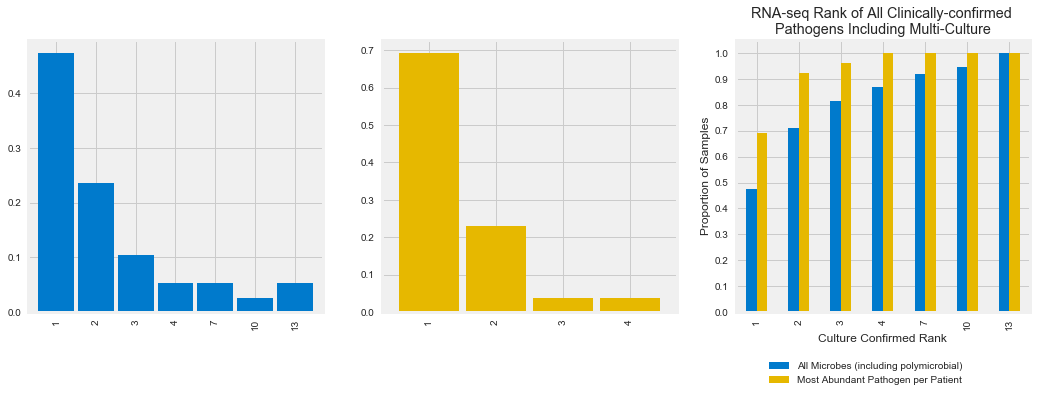

Cummulative # of Microbes at each Rank:
1     18
2     27
3     31
4     33
7     35
10    36
13    38
dtype: int64

Cummulative # of Top Microbes at each Rank:
1    18
2    24
3    25
4    26
dtype: int64


    All Microbes (including polymicrobial)  Most Abundant Pathogen per Patient
1                                 0.473684                            0.692308
2                                 0.710526                            0.923077
3                                 0.815789                            0.961538
4                                 0.868421                            1.000000
7                                 0.921053                            1.000000
10                                0.947368                            1.000000
13                                1.000000                            1.000000


In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

all_ranks = {}  # dictionary, keys are the ranks and values are the number of times a microbe had that rank
only_first_ranks = {}
s = 0
s2 = 0

for i in list_of_files:   # loop through all the files
    sample_id = i.split('/')[-1].split('.')[-3]   # get the sample ID from filename
    # get the metadata for that sample ID
    metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]   
    # get the true classification for that sample
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]           
    
    # use dictionary of ranks created while plotting per-sample rM RNA and rM DNA (above); parse for plotting.
    for j in ranks_from_culture[i]:   
        s += 1
        try:
            all_ranks[j] += 1
        except:
            all_ranks[j] = 1
    if(len(ranks_from_culture[i]) > 0):  # if something grew in culture
        s2 += 1
        try:
            only_first_ranks[ranks_from_culture[i][0]] += 1
        except:
            only_first_ranks[ranks_from_culture[i][0]] = 1
        

# plot the first panel with proportions of all microbes
(pd.Series(all_ranks)/s).plot('bar',width=.9, ax=axes[0],color='#007acc')

# plot the second panel with proportions including only the most abundant microbe per patient
(pd.Series(only_first_ranks)/s2).plot('bar',width=.9,ax=axes[1], color='#e6b800')

# loop through and convert count data to cummulative proportions
# cummulative proportions for the "all microbes" data
all_ranks_cummulative = all_ranks
all_ranks_cummulative[2] = all_ranks_cummulative[1] + all_ranks_cummulative[2]
all_ranks_cummulative[3] = all_ranks_cummulative[2] + all_ranks_cummulative[3]
all_ranks_cummulative[4] = all_ranks_cummulative[3] + all_ranks_cummulative[4]
all_ranks_cummulative[7] = all_ranks_cummulative[4] + all_ranks_cummulative[7]
if topX == 15:
    all_ranks_cummulative[10] = all_ranks_cummulative[10] + all_ranks_cummulative[7]
    all_ranks_cummulative[13] = all_ranks_cummulative[13] + all_ranks_cummulative[10]

# cummulative proportions for the "only top microbe" data
only_first_ranks_cummulative = only_first_ranks
only_first_ranks_cummulative[2] = (only_first_ranks_cummulative[1] + 
                                   only_first_ranks_cummulative[2])
only_first_ranks_cummulative[3] = (only_first_ranks_cummulative[2] +
                                   only_first_ranks_cummulative[3])
only_first_ranks_cummulative[4] = (only_first_ranks_cummulative[3] +
                                   only_first_ranks_cummulative[4])
    
# create a merged dataframe for final panel plot
cumm_rank_df = pd.DataFrame({'All Ranks': all_ranks_cummulative, 
                             'First Ranks': only_first_ranks_cummulative})
cumm_rank_df.fillna(26, inplace=True)
cumm_rank_df_norm = cumm_rank_df/cumm_rank_df.max()
cumm_rank_df_norm.columns=['All Microbes (including polymicrobial)',
                           'Most Abundant Pathogen per Patient']

# plot the side-by-side representation
ax = cumm_rank_df_norm.plot(kind="bar", ax=axes[2], color = ['#007acc','#e6b800']
                           ).legend(bbox_to_anchor=(.8, -.15))

# append details to the plot (axes and legend) on third panel
plt.yticks(np.arange(0,1.05,.1))
plt.ylim(0,1.05)
plt.xlabel("Culture Confirmed Rank")
plt.ylabel("Proportion of Samples")
plt.title("RNA-seq Rank of All Clinically-confirmed \nPathogens Including Multi-Culture")

plt.show()

# print the data used to generate the plots
print("Cummulative # of Microbes at each Rank:")
print(pd.Series(all_ranks_cummulative))

print("\nCummulative # of Top Microbes at each Rank:")
print(pd.Series(only_first_ranks_cummulative))

print("\n")
print(cumm_rank_df_norm)

In [11]:
# Get the sensitivity/specificity for identifying microbes as the patient-level.
# Did we pick up the microbe at all by NGS? 
# Note: This is separate from the linear model for identifying putative pathogens

had_cultured_organism = 0
at_least_one_organism_identified_by_ngs = 0
all_organisms_identified_by_ngs = 0
total_number_organisms_culture = 0
total_number_organisms_anyNGS = 0

for i in list_of_files:
    sample_id = i.split('/')[-1].split('.')[-3]
    metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]
    bac = full[i]

    try:
        if tc == 1:
            
            #cmd will fail if nan, so since it doesn't fail there was a cultured organism
            organism_list = metadata.loc[metadata_id]['organism'].split(',') 
            
            total_number_organisms_culture += len(organism_list)
            if(len(organism_list) > 0):    
                had_cultured_organism += 1
                ID_by_NGS = [bac.loc[i]['Genus'] for i in bac.index if 
                             bac.loc[i]['Genus'] in organism_list]
                
                total_number_organisms_anyNGS  += len(ID_by_NGS) 
                    
                if len(ID_by_NGS) > 0:
                    at_least_one_organism_identified_by_ngs += 1
                    
                if len(set(ID_by_NGS)) == len(set(organism_list)):
                    all_organisms_identified_by_ngs += 1
                else:
                    print(i.split('/')[-1] + " is missing the following organisms by NGS:")
                    print(set(organism_list)-set(ID_by_NGS))
    except:
        if tc == 1:
            #if tc is 1 and no organism is listed, we want to know...otherwise skip
            print(metadata.loc[metadata_id]['organism'])  

print("# of patients that had a cultured organism: " 
      + str(had_cultured_organism))
print('# of patients that had at least one cultured organism identified in NGS: '
      + str(at_least_one_organism_identified_by_ngs))
print('# of patients that had all cultured organisms identified in NGS: '
      + str(all_organisms_identified_by_ngs))

print('Total # of organisms in culture: ' 
      + str(total_number_organisms_culture))
print('Total # of organisms in culture, identified AT ALL by NGS: ' 
      + str(total_number_organisms_anyNGS))


# of patients that had a cultured organism: 26
# of patients that had at least one cultured organism identified in NGS: 26
# of patients that had all cultured organisms identified in NGS: 26
Total # of organisms in culture: 38
Total # of organisms in culture, identified AT ALL by NGS: 38


# Set-up Data from LR and RB Models

> "Microbes identified by clinician-ordered diagnostics plus all viruses with established respiratory pathogenicity in the LRTI+C+M group were categorized as pathogens (n=12 in derivation cohort and n=26 in validation cohort, Table S1). Any additional microbes identified by mNGS were considered commensals(n = 155 in derivation cohort, n=174 in validation cohort)."

This code creates the main data structure that will be used to implement the rules-based and logistic regression models - a dataframe with one line per sample containing 
- RNAvalue
- DNAvalue
- groupID
- rank
- microbeID
- patient
- pathogenicity
- virus status
- and whether the microbe was identified in culture.

In [12]:
# Parse out the relevant features from Figure S1 - generated in main analysis above.
sensitivity_DF = pd.DataFrame.from_dict({'RNAvalue':RNA_value,
                                         'DNAvalue':DNA_value,
                                         'groupID':groupid,
                                         'positive':positive,
                                         'pathogenic':pathogenic,
                                         'nrnt':nrnt_model,
                                         'ranks':ranks,
                                         'virus':virus,
                                         'microbe':microbe_id,
                                         'microbe_genus':microbe_id_genus, 
                                         'patient':patient_id, 
                                         'nt_Z_rna':nt_genusz_rna,
                                         'nt_Z_dna':nt_genusz_dna}, orient='columns')

X = sensitivity_DF[['RNAvalue','DNAvalue','nrnt','groupID','ranks','microbe',
                    'patient','microbe_genus','nt_Z_rna','nt_Z_dna']]
X[['pathogenic_red']] = sensitivity_DF[['pathogenic']] == 'red'
X[['pathogenic_green']] = sensitivity_DF[['virus']] == 'green'
X[['pathogenic_darkblue']] = sensitivity_DF[['pathogenic']] == 'darkblue'
X['positive'] = sensitivity_DF[['positive']]!="white"

# Full training dataset
X.fillna(0,inplace=True)
Y = X[['positive']]
Y = Y['positive'].tolist()

# Separate out by group membership for training and analysis of True Positive / True Negative
X_g1 = X[X['groupID'] == 1]
X_g2 = X[X['groupID'] == 2]
X_g3 = X[X['groupID'] == 3]
X_g4 = X[X['groupID'] == 4]
X_g1g4 = pd.concat([X_g1, X_g4], axis=0)

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_g1 = X_g1[['positive']]
Y_g1 = Y_g1['positive'].tolist()
Y_g2 = X_g2[['positive']]
Y_g2 = Y_g2['positive'].tolist()
Y_g3 = X_g3[['positive']]
Y_g3 = Y_g3['positive'].tolist()
Y_g4 = X_g4[['positive']]
Y_g4 = Y_g4['positive'].tolist()
Y_g1g4 = X_g1g4[['positive']]
Y_g1g4 = Y_g1g4['positive'].tolist()

X.to_csv('./output/' + output_directory + '/microbe_model_data.csv')  # save full dataset to .csv
X.head() # demo of training data

,RNAvalue,DNAvalue,nrnt,groupID,ranks,microbe,patient,microbe_genus,nt_Z_rna,nt_Z_dna,pathogenic_red,pathogenic_green,pathogenic_darkblue,positive
0,2.097847,1.610554,1,1,0,Staphylococcus aureus ( 1280 ),mBAL-212-RNA-TA1-B10.report.csv,Staphylococcus ( 1279 ),0.06,-0.16,True,False,False,True
1,0.488551,0.904174,1,1,1,Streptococcus mitis ( 28037 ),mBAL-212-RNA-TA1-B10.report.csv,Streptococcus ( 1301 ),-0.18,-0.18,False,False,True,False
2,0.155336,0.178977,1,1,0,Staphylococcus aureus ( 1280 ),mBAL-225-RNA-TA1-B10.report.csv,Staphylococcus ( 1279 ),-0.27,-0.27,True,False,False,True
3,0.056905,0.086360,1,1,1,Candida albicans ( 5476 ),mBAL-225-RNA-TA1-B10.report.csv,Candida ( 1535326 ),-0.21,-0.19,False,False,True,False
4,3.591451,2.921062,1,1,0,Enterobacter cloacae ( 550 ),mBAL-298-RNA-TA1-B10.report.csv,Enterobacter ( 547 ),41.66,8.74,True,False,False,True


In [13]:
# separate G1/G4 data further into training and test sets 
# these sample names were identified by random selection of host RNA-seq data based on RNA-seq batches.
X_g1_train = X_g1[X_g1['patient'].isin(training_sample_names)]
X_g4_train = X_g4[X_g4['patient'].isin(training_sample_names)]
X_g1g4_train = pd.concat([X_g1_train,X_g4_train])
Y_g1_train = X_g1_train['positive'].tolist()
Y_g4_train = X_g4_train['positive'].tolist()

X_g1_test = X_g1[~X_g1['patient'].isin(training_sample_names)]
X_g4_test = X_g4[~X_g4['patient'].isin(training_sample_names)]
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1_test = X_g1_test['positive'].tolist()
Y_g4_test = X_g4_test['positive'].tolist()

print("Training data contains: " + str(X_g1g4_train.shape[0]) + 
      " total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which " + 
      str(X_g1g4_train[X_g1g4_train['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")
print("The test data contains: " + str(X_g1g4_test.shape[0]) + 
      " total microbes from all remaining patients in the validation cohort, of which " + 
      str(X_g1g4_test[X_g1g4_test['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")

Training data contains: 167 total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which 12 microbes are considered POSITIVE (grew in culture).
The test data contains: 200 total microbes from all remaining patients in the validation cohort, of which 26 microbes are considered POSITIVE (grew in culture).


## Quantify the observation that RNA rpM is generally > DNA rpM 

> "RNA-seq yielded a greater abundance of sequences as compared to DNA-seq for 78% of identified microbes, with a median of 2.2 times more reads per microbe."

% of all microbes with RNA > DNA rpM: 0.7792553191489362
Mean: 11.431095136746674
Min: 0.0042561205273069684
25th percentile: 1.0635883800823975
50th percentile: 2.2264337508239946
75th percentile: 7.191729323308271
Max: 563.7457627118646


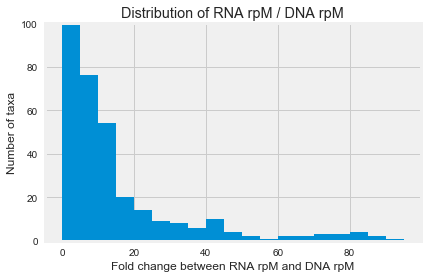

In [14]:
# quantify the difference in RNA rpm v. DNA rpm 

# not including RNA viruses in this calculation bc they can't have DNA
not_virus = X[X['DNAvalue'] > 0]                                   
# reverse the log conversion to report true rpm difference
dif_RNAvDNAx = 10**not_virus['RNAvalue']-10**not_virus['DNAvalue']  
dif_RNAvDNA = (10**not_virus['RNAvalue'])/10**not_virus['DNAvalue']

# add column to dataframe to ease reporting of analysis
not_virus['RNAminusDNA'] = dif_RNAvDNA                             

# report the statistics:
print("% of all microbes with RNA > DNA rpM: " + str(sum(dif_RNAvDNAx > 0)/len(dif_RNAvDNA)))
print("Mean: " + str(np.mean(dif_RNAvDNA)))
print("Min: " + str(np.min(dif_RNAvDNA)))
print("25th percentile: " + str(np.percentile(dif_RNAvDNA, 25)))
print("50th percentile: " + str(np.percentile(dif_RNAvDNA, 50)))
print("75th percentile: " + str(np.percentile(dif_RNAvDNA, 75)))
print("Max: " + str(np.max(dif_RNAvDNA)))

# plot histogram of the differences
plt.hist(dif_RNAvDNA, bins=[i*5 for i in range(0,20)])
plt.title("Distribution of RNA rpM / DNA rpM")
plt.xlabel("Fold change between RNA rpM and DNA rpM")
plt.ylabel("Number of taxa")
plt.ylim(0,100)
plt.show()

## Execute Rules-Based Model (RBM) for distinguishing between 'pathogens' and 'commensals'

> "In the RBM, respiratory microbes from each patient were assigned an abundance score based  onthe  sum  of log(RNA-Seq)and log(DNA-Seq) genus reads  per million  reads  mapped (rpm) (Table S3A). After ranking microbes by this abundance score, the greatest score difference between sequentially ranked microbes was identified and used to distinguish the group of highest-scoring microbes within each patient (Fig 2A, Fig S1). These high scoring microbes plus all RNA viruses detected at a conservative  threshold  of > 0.1  rpm were  indexed  against  an a  priori developed table of established lower respiratory pathogens derived from landmark surveillance studies and clinical guidelines (Table S2B), and if present were identified as putative pathogens by the RBM (4, 30–32)."

Plot the RNA x DNA projection for all microbes - those identified by the RBM are filled, those identified by standard clinical microbiology are red.

Group 1 RBM Results:


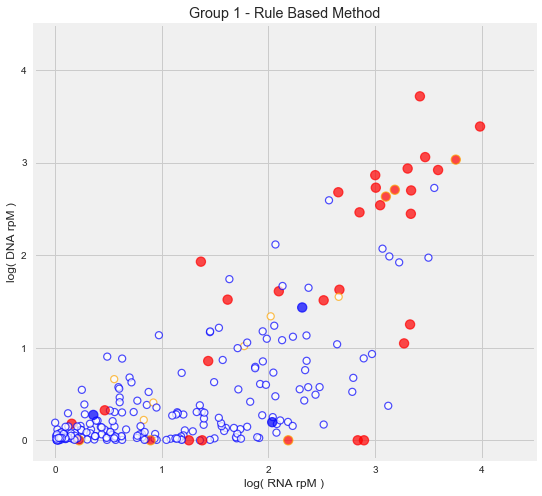

Group 2 RBM Results:


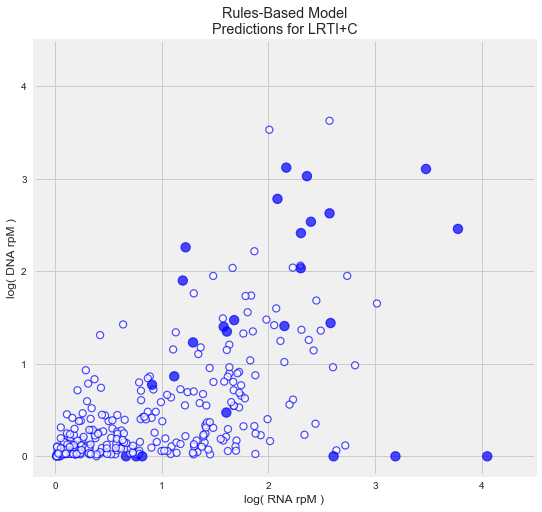

Group 3 RBM Results:


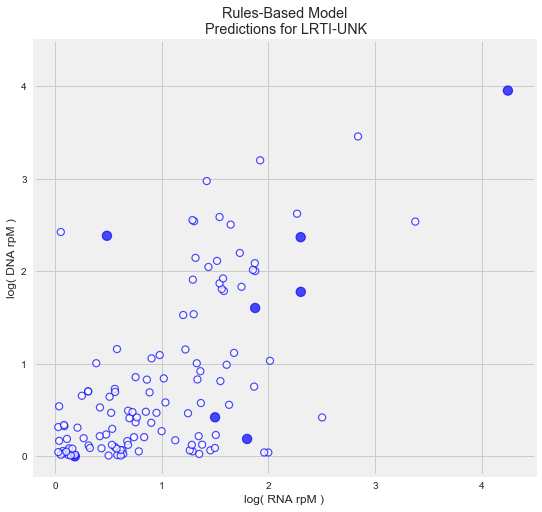

Group 4 RBM Results:


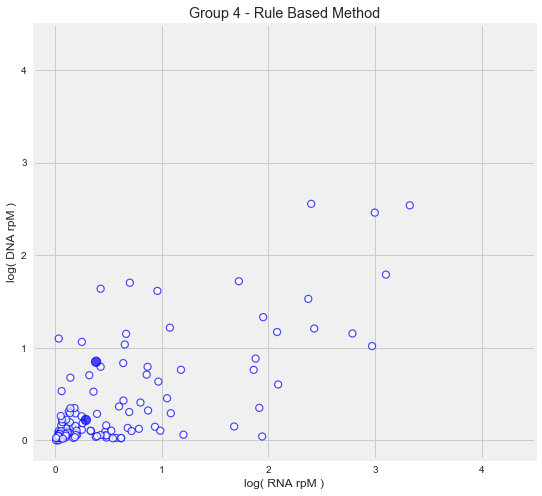

In [15]:
annotate_plots = False # do not want to write microbe names on the plots

# run RBM on Group 1 and Group 4 to generate the combined prediction Figure 2A
# We don't care about training and test sets in the RBM because each sample is 
# processed entirely independently

print("Group 1 RBM Results:") # Group 1 Only
rbm_g1 = pathogen_functions.apply_rule_based_method_cluster(X_g1, 
                                                            Y_g1, 
                                                            1, 
                                                            './output/' + output_directory +
                                                            '/rbm_1', 
                                                            rbm_method_plot=False)
rbm_g1.to_csv('./output/' + output_directory + '/RBM_G1.csv')
plt.show()

print("Group 2 RBM Results:") # Group 2 Only
rbm_g2 = pathogen_functions.apply_rule_based_method_cluster(
    X_g2, 
    Y_g2,
    2,
    './output/' + output_directory + '/FigureS3A',
    title="Rules-Based Model\n Predictions for LRTI+C ",
    rbm_method_plot=False)
rbm_g2.to_csv('./output/' + output_directory + '/RBM_G2.csv')
plt.show()

print("Group 3 RBM Results:") # Group 3 Only
rbm_g3 = pathogen_functions.apply_rule_based_method_cluster(
    X_g3,                                                         
    Y_g3, 
    3, 
    './output/' + output_directory + '/FigureS3C', 
    title="Rules-Based Model\n Predictions for LRTI-UNK", 
    rbm_method_plot=False)
rbm_g3.to_csv('./output/' + output_directory + '/RBM_G3.csv')
plt.show()

print("Group 4 RBM Results:") # Group 4 Only
rbm_g4 = pathogen_functions.apply_rule_based_method_cluster(
    X_g4, 
    Y_g4, 
    4, 
    './output/' + output_directory + '/rbm_4', 
    rbm_method_plot=False)
rbm_g4.to_csv('./output/' + output_directory + '/RBM_G4.csv')
plt.show()

# Train and Evaluate Logistic Regression Model (LRM) 

First, for distinguishing between 'pathogens' and 'commensals'; then, for separating LRTI+C+M and no-LRTI patients.

> "We thus employed machine  learning  todistinguish  respiratory  pathogens  from  commensalsusingalogistic regression  model  (LRM)trained  on  microbes detectedin the derivation cohortpatients (n=20) using the predictor variables of: RNA-Seq rpm, DNA-Seq rpm, rank by RNA-Seqrpm, established LRTI pathogen (yes/no),and virus (yes/no).These features were selected to preferentially favor highly abundant organisms with established pathogenicity in the lung, but still permit detection of uncommon taxa that could represent putative pathogens."

# Training v. Test Set - LR Analysis 

## Assess Model Stability:
Run LR model for 1000 rounds of cross-validation within the Derivation Cohort, further splitting the data intoa training set = 70% and test set = 30% at each iteration.

In [16]:
# SAME AS BLOCK BELOW BUT WITH "_iterative" appended to AUC plot 

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

print("sklearn version:")
print(sklearn.__version__)

PROBABILITY_THRESHOLD = 0.36 # 0.38 #0.278 #

print("Basic Stats about number of Positive/Negative Cases and Features of each group:\n")
X_pos = X_g1g4_train[X_g1g4_train['positive'] == True]
X_neg = X_g1g4_train[X_g1g4_train['positive'] == False]
print("Number of PATHOGENS in the training set:")
print(X_pos.shape)
print("Number of COMMENSALS in the training set:")
print(X_neg.shape)
print("\nRNA: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['RNAvalue']],X_neg[['RNAvalue']]).pvalue))
print("DNA: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['DNAvalue']],X_neg[['DNAvalue']]).pvalue))
print("RANKS: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['ranks']],X_neg[['ranks']]).pvalue))
print("is respiratory pathogen: Percent in PATHOGENS = " + 
      str(Counter(list(X_pos['pathogenic_red']))[True]/X_pos.shape[0]) + 
      ", Percent in COMMENSALS = " + 
      str(Counter(list(X_neg['pathogenic_red']))[True]/X_neg.shape[0]))
print("is virus: Percent in PATHOGENS = " + 
      str(Counter(list(X_pos['pathogenic_green']))[True]/X_pos.shape[0]) +
      ", Percent in COMMENSALS = " + 
      str(Counter(list(X_neg['pathogenic_green']))[True]/X_neg.shape[0]))
print("\n-----")



training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']
many_rounds_train_auc = []
many_rounds_test_auc = []

tprs_iterative = []
aucs_iterative = []
mean_fpr_iterative = np.linspace(0, 1, 100)

#X = X_g1g4_train[training_variables] 

X_combo = pd.concat([X_g1_train,X_g4_train])  # train on both group 1 and group 4 patients
y_combo = Y_g1_train + Y_g4_train   

# track num iterations w/ 1 class (likely the negative class) in the test set
oneclasspresent = 0    
c = ['blue','red']

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X_combo[training_variables], y_combo, test_size=0.3
    ) 
    
    try:
        lr = linear_model.LogisticRegression(C=1000000)
        lr.fit(X_train, y_train)
        
        many_rounds_train_auc.append(
            metrics.roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
        many_rounds_test_auc.append(
            metrics.roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
        
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test, lr.predict_proba(X_test)[:,1], pos_label=1)  
        tprs_iterative.append(interp(mean_fpr_iterative, fpr, tpr))
        tprs_iterative[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs_iterative.append(roc_auc)
        
    except:
        # if only 1 class is present, cannot compute the req'd stats; skip this iteration
        oneclasspresent += 1    

print("\nWARNING: only one class was present in the test set for " + str(oneclasspresent) +
      " rounds of train/test split")
print("\n-----\n\nOutput metrics (at threshold = " + str(PROBABILITY_THRESHOLD) + ")")
print("Logistic regression Train AUC for 1000 rounds CV :: ", np.mean(many_rounds_train_auc))
print("Logistic regression Test AUC for 1000 rounds CV :: ", np.mean(many_rounds_test_auc))

sklearn version:
0.18.1
Basic Stats about number of Positive/Negative Cases and Features of each group:

Number of PATHOGENS in the training set:
(12, 14)
Number of COMMENSALS in the training set:
(155, 14)

RNA: wilcox p =  0.00024387541251201677
DNA: wilcox p =  0.003549198115785677
RANKS: wilcox p =  3.510602128601564e-06
is respiratory pathogen: Percent in PATHOGENS = 0.9166666666666666, Percent in COMMENSALS = 0.15483870967741936
is virus: Percent in PATHOGENS = 0.16666666666666666, Percent in COMMENSALS = 0.01935483870967742

-----


-----

Output metrics (at threshold = 0.36)
Logistic regression Train AUC for 1000 rounds CV ::  0.9782610825577334
Logistic regression Test AUC for 1000 rounds CV ::  0.9374423836458877


## Obtain final predictions (separating true Training and Test sets)

### Leave-one-patient-out (LOPO) cross-validation to obtain Training Set predictions

LOPO-CV enables us to produce microbe predictions for all microbes in patients in the pre-established derivation set.

In [17]:
# LOPO-CV schematic is as follows:
# IN EACH ITERATION...
#  1. Remove all microbes from one patient
#  2. Train on microbes from all other patients
#  3. Predict for all microbes in the held-out patient
# This results in the predicted [pathogen v. commensal] probability for each microbe 
# in the training set

#
# RUN LOPO-CV ON ALL GROUP 1 AND GROUP 4 PATIENTS
#


# full training data
X_combo = X_g1g4_train 
Y_combo = X_combo[['positive']]

patients_to_remove = list(set(X_combo['patient']))  # names of each patient in the training set
predictions = []
truths = []
training_auc = []
c = ['blue','red']
patient_max_scores = {}
patient_groups = {}

for i in patients_to_remove:  # loop through all patients
    
    # training set is all combo microbes that are not from patient = i
    X_train_sub = X_combo[X_combo['patient'] != i]   
    X_train = X_train_sub[training_variables] 
    y_train = X_train_sub['positive']

    # test set is all combo microbes that are from patient = i
    X_test_sub = X_combo[X_combo['patient'] == i]   
    X_test = X_test_sub[training_variables] 
    y_test = X_test_sub['positive']

    lr = linear_model.LogisticRegression(C=1000000) # large C, effectively no regularization
    lr.fit(X_train, y_train)                        # fit the logistic regression model
    p_test = lr.predict_proba(X_test)[:,1]          # predict on the left-out sub test set
    p_train = lr.predict_proba(X_train)[:,1]        # predict on the training set 
    
    # METRICS for evaluating model performance
    predictions = predictions + list(p_test)        # append subset predictions to list of all predictions
    truths = truths + list(y_test)                  # append truth values to list of all true classifications
    training_auc.append(metrics.roc_auc_score([int(j) for j in y_train], p_train))      # calculate AUC for training subset
        
    # track the maximum pathogen v. commensal score per patient
    patient_max_scores[i] = max(list(p_test))  
    patient_groups[i] = list(X_test_sub['groupID'])[0]   # track the LRTI group
        
    count = 0
    
    # append the pathogen v. commensal LRM "score" value to each row of the X_combo matrix ...
    # ... for downstream plots 
    for j in X_combo[X_combo['patient'] == i].index:  
        X_combo.loc[j,'score'] = p_test[count]
        count += 1
        
print("Mean AUC for LOPO-CV training: " + str(np.mean(training_auc)))  
print("\nTotal AUC for LOPO-CV predictions: " + str(metrics.roc_auc_score([int(i) for 
                                                                           i in truths], 
                                                                          predictions)))
pathogen_functions.get_CI([int(i) for i in truths], predictions, 1000);

# Youden's index for pathogen v. commensal model 
# We are not using this in the analysis for consistency in threshold btwn pathogen v. 
# commensal and LRTI v. no-LRTI models
# youdens_patho_commensal_model = pathogen_functions.Find_Optimal_Cutoff([int(i) for i in truths],
#                                                                            predictions)
# print("Youden's training pathogen v. commensal: " + str(youdens_patho_commensal_model))

Mean AUC for LOPO-CV training: 0.9764220774224505

Total AUC for LOPO-CV predictions: 0.9026881720430108
Original ROC area: 0.903, [0.757 - 0.993]


#### Training Set: Use the max. LRM score per patient to distinguish between LRTI v. no-LRTI patients

> "We recognized that the highest per-patient LRM pathogen versus commensal probability value differed significantly between LRTI+C+M and no-LRTI subjects (p = 3.8x10-4 by Wilcoxon rank sum). As such, we hypothesized that this value might have utility not only for pathogen versus commensal prediction, but also for LRTI prediction in general. Testing this idea, we found that the maximum per patient LRM probability value predicted LRTI status with an AUC of 0.97 (95% CI = 0.90-1.00) in the derivation cohort and 0.96 (95% CI = 0.86-1.00) inthe validation cohort (FigS3)."

AUC for distinguishing LRTI+C+M v. no-LRTI patients = 0.97


No handles with labels found to put in legend.


Original ROC area: 0.970, [0.905 - 1.0]

At probability threshold = 0.36
TP, FP, TN, FN
(10, 1, 9, 0)


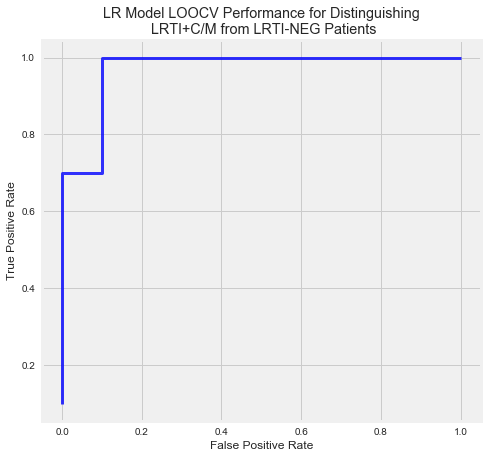

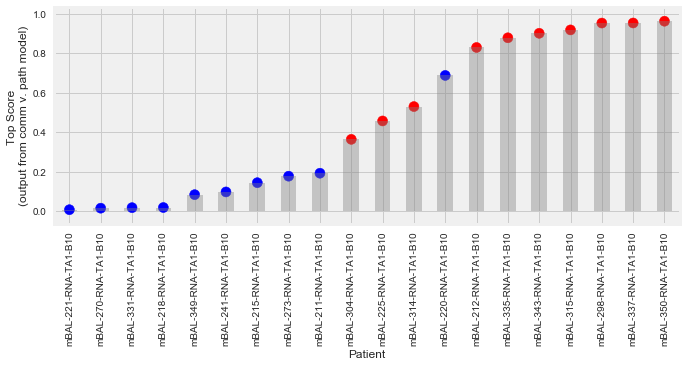

mBAL-221-RNA-TA1-B10    0.009081
mBAL-270-RNA-TA1-B10    0.016788
mBAL-331-RNA-TA1-B10    0.019438
mBAL-218-RNA-TA1-B10    0.020167
mBAL-349-RNA-TA1-B10    0.085162
mBAL-241-RNA-TA1-B10    0.098944
mBAL-215-RNA-TA1-B10    0.145631
mBAL-273-RNA-TA1-B10    0.178563
mBAL-211-RNA-TA1-B10    0.193578
mBAL-304-RNA-TA1-B10    0.364818
mBAL-225-RNA-TA1-B10    0.457866
mBAL-314-RNA-TA1-B10    0.530623
mBAL-220-RNA-TA1-B10    0.688044
mBAL-212-RNA-TA1-B10    0.829438
mBAL-335-RNA-TA1-B10    0.878395
mBAL-343-RNA-TA1-B10    0.901141
mBAL-315-RNA-TA1-B10    0.918216
mBAL-298-RNA-TA1-B10    0.952901
mBAL-337-RNA-TA1-B10    0.953251
mBAL-350-RNA-TA1-B10    0.962198
Name: 0, dtype: float64
P-value for top microbe score in LRTI+C/M versus LRTI-NEG: 0.0003810584520506855


In [18]:
# USE THE PATIENT-SPECIFIC MAX SCORE VALUE TO CREATE A CLASSIFIER FOR G1 V. G4 PATIENTS...
# actually, we only have 1 feature so we will just evaluate the AUC.

scores = []
group = []
patient_names = []
for i in patient_max_scores.keys():
    scores.append(patient_max_scores[i])
    group.append(patient_groups[i])
    patient_names.append(i)

# Generate AUC curve for predicting Group 1 v. Group 4 from the top microbe score
#youdens_patient_microbe_model = pathogen_functions.Find_Optimal_Cutoff(group, scores)
#print("Youden's training patient microbe: " + str(youdens_patient_microbe_model))
fpr, tpr, thresholds = metrics.roc_curve(group, scores, pos_label=1)  
print("AUC for distinguishing LRTI+C+M v. no-LRTI patients = " + 
      str(metrics.roc_auc_score([int(i==1) for i in group], scores)))
pathogen_functions.get_CI([int(i==1) for i in group], scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(pathogen_functions.perf_measure([i > PROBABILITY_THRESHOLD for i in scores], 
                                      [int(i==1) for i in group]))


# PLOT: Figure S3
# AUC curve for LRTI+C+M v. no-LRTI using the max. pathogen v. commensal probability per patient
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b', lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model LOOCV Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2.pdf')
plt.show()

# PLOT: max predicted probability score by patient - for visualization and 
# double-checking feasability of AUC
plt.ylabel("Top Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(patient_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 1) for i in group]
df.sort_values(by=0,inplace=True)
df[0].plot(kind='bar',color='grey',figsize=(10,4), alpha=.4)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
plt.show()
print(df[0])  # print out the patient ID and max microbe score (same as plot)


# evaluate the p-value of scores from group 1 and group 4
group1_scores = []
group4_scores = []
for i in range(len(group)):
    if int(group[i] == 1):
        group1_scores.append(scores[i])
    else:
        group4_scores.append(scores[i])

print("P-value for top microbe score in LRTI+C/M versus LRTI-NEG: " + 
      str(scipy.stats.ranksums(group1_scores,group4_scores).pvalue))

# Create the data for per-patient heatmap view showing all microbes that passed 
# the threshold for all patients (in groups 1 and group 4)
creating_matrix_from_Xcombo = X_combo[X_combo['score'] > PROBABILITY_THRESHOLD]
patient_by_microbe_predicted_combo = creating_matrix_from_Xcombo[['microbe',
                                                                  'patient',
                                                                  'microbe_genus']]
patient_by_microbe_predicted_combo.index = [i for i in range(len(
    patient_by_microbe_predicted_combo.index))]


### Pathogen v. Commensal LRM model applied to Test Set and LRTI+C and unk-LRTI patient groups

> "Combiningthe RBM and LRM identified more putative pathogens than either model alone andrevealed  a  potential  LRTI  etiology  in  62%  (n=21)of the  LRTI+C patients  with  clinically adjudicated  LRTI  but  negative  microbiologic  testing (Figs3,  S2,Table S3A).  Compared  to clinician-ordered  diagnostics,  this  permitted  a microbiologic  diagnosis  in  a  greater  number  of LRTI-positive subjects  (78% vs 43%, p  < 1.00  x10-4by McNemar’s test, Fig  3)."

How to interpret the following plots:
- IF THE EDGE IS RED, it was identified in culture (and should be filled in, true positive)
- IF a red edge is not filled in, then it is a false negative.
- IF an edge is blue, then it was not identified in culture (and should not be filled in, true negative)
- IF a blue circle is filled in then it is a false positive.

LRM Model Coefficients for final pathogen v. commensal trained model:
['RNAvalue', 'DNAvalue', 'pathogenic_red', 'pathogenic_green', 'ranks']
[[-0.54594061  1.55841376  4.60924944  1.34596736 -1.03127729]]

 # of Pathogens v. Commensals in Training and Test sets, respectively:
Counter({False: 155, True: 12})
Counter({False: 174, True: 26})


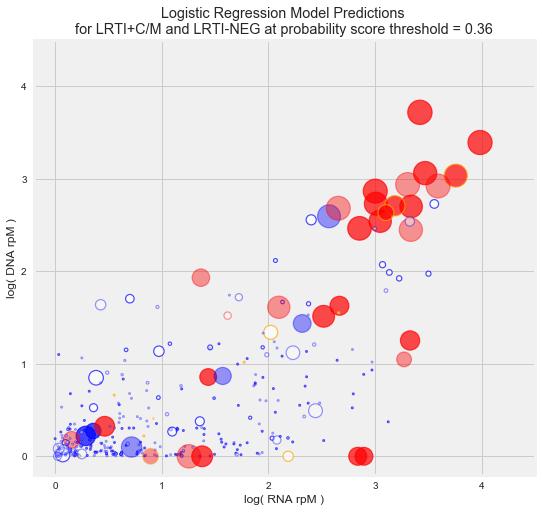

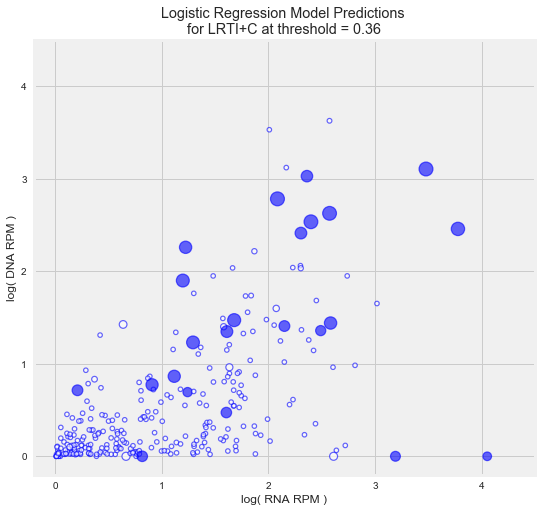

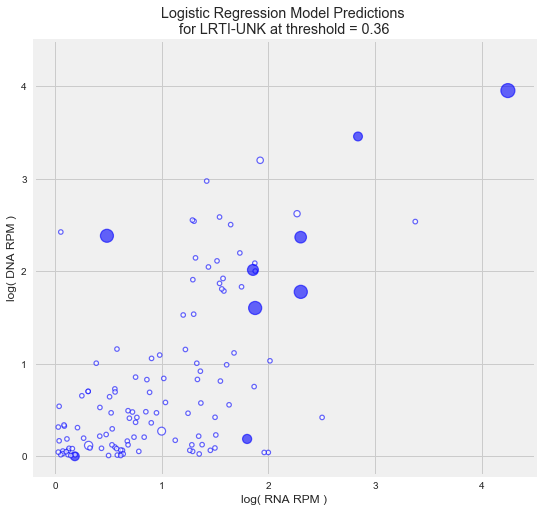

In [21]:
# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

# create fresh linear model; large C to run non-regularized regression
lr = linear_model.LogisticRegression(C=1000000)
training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']

# Train on all Group 1 and Group 4 patients
lr = lr.fit(X_combo[training_variables],Y_combo)

print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)

# save the combined model to a pickle file 
pickle.dump(lr, open('./output/' + output_directory + '/mBAL_g1g4combo_logRegModel', 'wb'))  

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
c2 = ['blue','red'] # for G2 and G3 projection pplots

# establish the test set
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1g4_test = list(X_g1g4_test['positive'])

print("\n # of Pathogens v. Commensals in Training and Test sets, respectively:")
print(Counter(Y_combo['positive']))
print(Counter(Y_g1g4_test))

# Plot predicted probabilities for group 1 TEST SET patients' microbes
predicted = lr.predict_proba(X_g1g4_test[training_variables])
X_g1g4_test['score'] = predicted[:,1]  # append the predicted probabilities to the data matrix

# PLOT: RNA v. DNA plot with microbes shown with probabilities.
plt.figure(figsize=[8,8])

# visualize the test set in RNA rM by DNA rM space;
plt.scatter(X_g1g4_test['RNAvalue'],
            X_g1g4_test['DNAvalue'],
            edgecolor=[c[int(X_g1g4_test.loc[i]['positive'])] 
                       if X_g1g4_test[X_g1g4_test['patient'] == 
                                      X_g1g4_test.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_g1g4_test.loc[i]['positive'])] == 'blue' 
                       or X_g1g4_test.loc[i]['score'] == max(
                           X_g1g4_test[(X_g1g4_test.patient == X_g1g4_test.loc[i]['patient']) 
                                       & (X_g1g4_test.positive == True)]['score']) 
                       else 'orange' for i in X_g1g4_test.index],
            s=[max(i*600,3) for i in X_g1g4_test['score']],
            linewidth=1.2,
            facecolor=[c[int(Y_g1g4_test[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g1g4_test)) ],
            alpha=.7) 

# add the scatterplot of predicted TRAINING microbes in RNA rM by DNA rM space;
plt.scatter(X_combo['RNAvalue'],
            X_combo['DNAvalue'],
            edgecolor=[c[int(X_combo.loc[i]['positive'])] 
                       if X_combo[X_combo['patient'] == 
                                  X_combo.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_combo.loc[i]['positive'])] == 'blue' 
                       or X_combo.loc[i]['score'] == max(
                           X_combo[(X_combo.patient == X_combo.loc[i]['patient'])
                                   & (X_combo.positive == True)]['score']) 
                       else 'orange' for i in X_combo.index],
            s=[max(i*600,3) for i in X_combo['score']],
            linewidth=1.2,
            facecolor=[c2[int(X_combo.iloc[i]['positive'])] if X_combo.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_combo['positive'])) ],
            alpha=.4)

xlim((-.2, 4.5))
ylim((-.2, 4.5))
plt.title(
    "Logistic Regression Model Predictions \nfor LRTI+C/M and LRTI-NEG at probability score threshold = " + 
    str(PROBABILITY_THRESHOLD))
plt.xlabel("log( RNA rpM )")
plt.ylabel("log( DNA rpM )")
plt.savefig('./output/' + output_directory + '/Figure2D.pdf')

if(annotate_plots):
    for i in range(len(Y_g1g4_test)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g1g4_test.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g1g4_test.iloc[i]['RNAvalue'] +
                          .1,X_g1g4_test.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, color='grey')     
    
plt.show()


# save the predicted probabilities for each microbe to write to file downstream
patient_by_microbe_predicted_g1g4_test = pd.DataFrame.from_dict({
    'microbe': [X_g1g4_test.iloc[i]['microbe'] for i in range(len(Y_g1g4_test))
         if predicted[:,1][i] > PROBABILITY_THRESHOLD ],
    'patient':[X_g1g4_test.iloc[i]['patient'] for i in range(len(Y_g1g4_test))
               if predicted[:,1][i] > PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g1g4_test.iloc[i]['microbe_genus'] for
                     i in range(len(Y_g1g4_test))if predicted[:,1][i] > 
                                   PROBABILITY_THRESHOLD ]})

print("\n\n")

#
# Predictions for Group 2 (LRTI+C) and Group 3 (unk-LRTI) patients
#

# LRTI+C PREDICTIONS

annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X_g2[training_variables])
plt.figure(figsize=[8,8])
plt.scatter(X_g2['RNAvalue'],X_g2['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g2],
            s=[max(i*200,20) for i in predicted[:,1]],
            linewidth=1.2,
            facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g2)) ],
            alpha=.6) 

xlim((-.2, 4.5))
ylim((-.2, 4.5))
if(annotate_plots):
    for i in range(len(Y_g2)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g2.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g2.iloc[i]['RNAvalue'] + .1,X_g2.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')     
plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')
patient_by_microbe_predicted_g2 = pd.DataFrame.from_dict({
    'microbe':[X_g2.iloc[i]['microbe'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g2.iloc[i]['patient'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g2.iloc[i]['microbe_genus'] for i in range(len(Y_g2)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})

# append the group 2 pathogen v. commensal model to the original data matrix
X_g2['score'] = predicted[:,1]


# unk-LRTI PREDICTIONS
predicted = lr.predict_proba(X_g3[training_variables]) 
plt.figure(figsize=[8,8])
plt.scatter(X_g3['RNAvalue'],X_g3['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g3],
            s=[max(i*200,20) for i in predicted[:,1]],
            linewidth=1.2,
            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g3)) ],
            alpha=.6)
xlim((-.2, 4.5))
ylim((-.2, 4.5))
if(annotate_plots):
    for i in range(len(Y_g3)):
        if True:
            try:
                sp = X_g3.iloc[i]['microbe'].split(' ')
            except: 
                sp = 'NA'
            pa = X_g3.iloc[i]['patient'].split('-')[1]
            plt.annotate(sp[0][0] + '. ' + sp[1] + ' - ' + pa,
                         (X_g3.iloc[i]['RNAvalue'] + .1,
                          X_g3.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')  
plt.title("Logistic Regression Model Predictions \nfor LRTI-UNK at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3D.pdf')
patient_by_microbe_predicted_g3 = pd.DataFrame.from_dict({
    'microbe':[X_g3.iloc[i]['microbe'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g3.iloc[i]['patient'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g3.iloc[i]['microbe_genus'] for i in range(len(Y_g3)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})
X_g3['score'] = predicted[:,1]


#### Test Set: Use the LRM score per patient to distinguish between LRTI v. no-LRTI patients

TEST AUC for predicting patients G1 v. G4 = 0.9553571428571429


No handles with labels found to put in legend.


Original ROC area: 0.955, [0.857 - 1.0]

At probability threshold = 0.36
TP, FP, TN, FN
(16, 1, 6, 0)


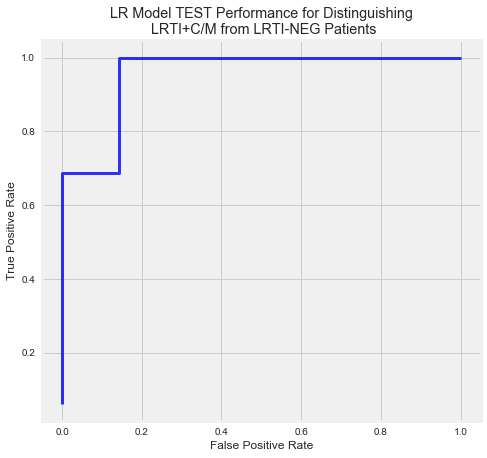

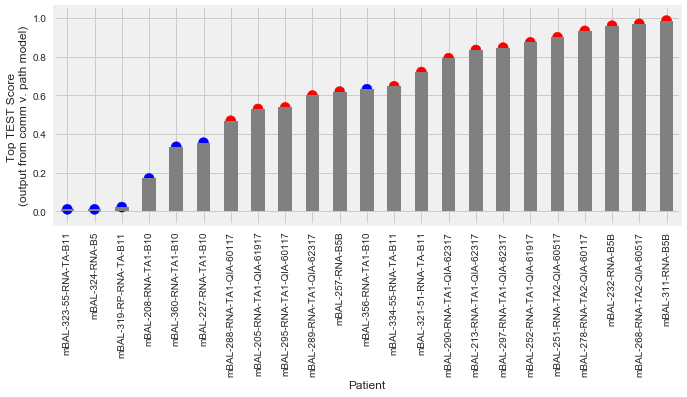

                                   0  color
mBAL-323-55-RNA-TA-B11      0.010348      0
mBAL-324-RNA-B5             0.010396      0
mBAL-319-RP-RNA-TA-B11      0.021957      0
mBAL-208-RNA-TA1-B10        0.170068      0
mBAL-360-RNA-TA1-B10        0.333700      0
mBAL-227-RNA-TA1-B10        0.355070      0
mBAL-288-RNA-TA1-QIA-60117  0.468222      1
mBAL-205-RNA-TA1-QIA-61917  0.529262      1
mBAL-295-RNA-TA1-QIA-60117  0.537225      1
mBAL-289-RNA-TA1-QIA-62317  0.598983      1
mBAL-257-RNA-B5B            0.619192      1
mBAL-356-RNA-TA1-B10        0.631435      0
mBAL-334-55-RNA-TA-B11      0.646519      1
mBAL-321-51-RNA-TA-B11      0.720255      1
mBAL-290-RNA-TA1-QIA-62317  0.791770      1
mBAL-213-RNA-TA1-QIA-62317  0.834258      1
mBAL-297-RNA-TA1-QIA-62317  0.846403      1
mBAL-252-RNA-TA1-QIA-61917  0.873706      1
mBAL-251-RNA-TA2-QIA-60517  0.899917      1
mBAL-278-RNA-TA2-QIA-60117  0.932974      1
mBAL-232-RNA-B5B            0.960033      1
mBAL-268-RNA-TA2-QIA-60517  0.96

In [22]:
# Get the per-patient max score for microbe patient model
test_max_scores = []
test_max_truth = []
for i in set(X_g1g4_test['patient']):
    test_max_scores.append(
        max(X_g1g4_test[X_g1g4_test['patient']==i]['score']))
    test_max_truth.append(
        metadata[metadata['RNAfilename']==i.split('.')[0]]['effective_group'].iloc[0])
    
# calculate performance metrics for the test set LRTI v. no-LRTI  
fpr, tpr, thresholds = metrics.roc_curve(test_max_truth, test_max_scores, pos_label=1)  
print("TEST AUC for predicting patients G1 v. G4 = " + 
      str(metrics.roc_auc_score([int(i==1) for i in test_max_truth], test_max_scores)))
pathogen_functions.get_CI([int(i==1) for i in test_max_truth], test_max_scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(pathogen_functions.perf_measure([i > PROBABILITY_THRESHOLD for i in test_max_scores], 
                                      [int(i==1) for i in test_max_truth]))


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b',
         lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model TEST Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2B.pdf')
plt.show()

# Create plot of max predicted probability score by patient - for visualization 
# and double-checking feasability of AUC
plt.ylabel("Top TEST Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(dict(zip(list(set(X_g1g4_test['patient'])),test_max_scores)),
                            orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 1) for i in test_max_truth]
df.sort_values(by=0,inplace=True)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
df[0].plot(kind='bar',color='grey',figsize=(10,4))
plt.show()

print(df)

#### Pathogen v. Commensal Figure (Publication Style)

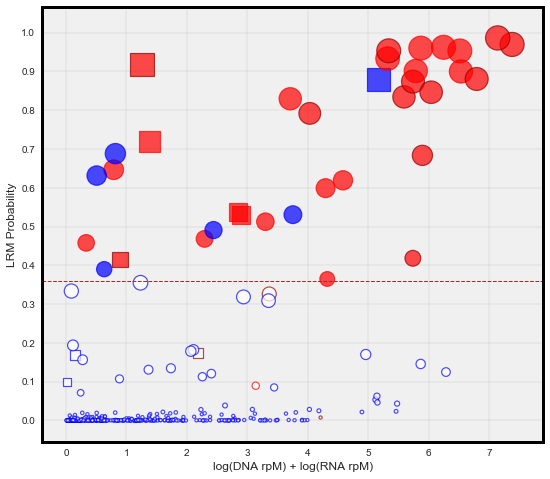

In [24]:
# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

#
# TRYING TO TRAIN ON TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red']
c2 = ['blue','red']

Y_g1g4_test = list(X_g1g4_test['positive'])

# separate the test set into viruses (square) and bacteria (round)
X_g1g4_test_v = X_g1g4_test[X_g1g4_test['pathogenic_green']==True]
X_g1g4_test_b = X_g1g4_test[X_g1g4_test['pathogenic_green']==False]

# separate the training set into viruses (square) and bacteria (round)
X_combo_v = X_combo[X_combo['pathogenic_green']==True]
X_combo_b = X_combo[X_combo['pathogenic_green']==False]

# identify polymicrobial cases
mult_pathos1 = pd.Series(Counter(list(X_g1g4_test[X_g1g4_test['positive']]['patient']) 
                                 + list(X_combo[X_combo['positive']]['patient'])))
mp1 = mult_pathos1[mult_pathos1>1]
mp =  list(mp1.index) # patients with multiple pathogens identified by clinical microbiology
sp = [i for i in mult_pathos1.index if i not in mp]  # patients with single pathogens

fig, ax = plt.subplots(figsize=[8,8], facecolor='white')
#ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')

plt.scatter(X_g1g4_test_v['DNAvalue'] + X_g1g4_test_v['RNAvalue'],X_g1g4_test_v['score'],
            edgecolor=[c[int(X_g1g4_test_v.loc[i]['positive'])] 
                       if X_g1g4_test_v.loc[i]['patient'] in (sp) 
                       or c[int(X_g1g4_test_v.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_g1g4_test_v.index],
            s=[max(i*600,10) for i in X_g1g4_test_v['score']],
            linewidth=1.2,
            marker='s',
            facecolor=[c2[int(X_g1g4_test_v.iloc[i]['positive'])] if X_g1g4_test_v.iloc[i]['score'] 
                       > PROBABILITY_THRESHOLD else 'white' for i in range(len(X_g1g4_test_v)) ],
            alpha=.7) 

plt.scatter(X_combo_v['DNAvalue']+X_combo_v['RNAvalue'],X_combo_v['score'],
            edgecolor=[c[int(X_combo_v.loc[i]['positive'])] 
                       if X_combo_v.loc[i]['patient'] in (sp) 
                       or c[int(X_combo_v.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_combo_v.index],
            s=[max(i*600,10) for i in X_combo_v['score']],
            linewidth=1.2,
            marker='s',
            facecolor=[c2[int(X_combo_v.iloc[i]['positive'])] if X_combo_v.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_combo_v['positive']))],
            alpha=.7)

plt.scatter(X_g1g4_test_b['DNAvalue']+X_g1g4_test_b['RNAvalue'], X_g1g4_test_b['score'],
            edgecolor=[c[int(X_g1g4_test_b.loc[i]['positive'])] 
                       if X_g1g4_test_b.loc[i]['patient'] in (sp) 
                       or c[int(X_g1g4_test_b.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_g1g4_test_b.index],
            s=[max(i*600,10) for i in X_g1g4_test_b['score']],
            linewidth=1.2,
            facecolor=[c[int(X_g1g4_test_b.iloc[i]['positive'])] if X_g1g4_test_b.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_g1g4_test_b)) ],
            alpha=.7) 

plt.scatter(X_combo_b['DNAvalue']+X_combo_b['RNAvalue'],X_combo_b['score'],
            edgecolor=[c[int(X_combo_b.loc[i]['positive'])] 
                       if X_combo_b.loc[i]['patient'] in (sp) 
                       or c[int(X_combo_b.loc[i]['positive'])] == 'blue'  
                       else 'darkred' for i in X_combo_b.index],
            s=[max(i*600,10) for i in X_combo_b['score']],
            linewidth=1.2,
            facecolor=[c2[int(X_combo_b.iloc[i]['positive'])] if X_combo_b.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_combo_b['positive'])) ],
            alpha=.7)

plt.axhline(y=PROBABILITY_THRESHOLD, color='firebrick', linestyle='--',lw=1)
plt.yticks(np.arange(0, 1.1, .1))
plt.xlabel("log(DNA rpM) + log(RNA rpM)")
plt.ylabel("LRM Probability")
ax.grid(linestyle='-', linewidth='0.25', color='#A9A9A9')
plt.savefig('./output/' + output_directory + '/Figure2C_v2_virbac.pdf',transparent=True)
plt.show()


#### LRM ROC Plot (Publication version)

This plot puts together the following:
1. The mean ROC curve and standard deviation for 1000 rounds of 70/30 training/test sub-split in the Training Set
2. The ROC curve for LOPO-CV in the training set
3. The ROC curve for validation with the test set.

Original ROC area: 0.903, [0.763 - 0.995]
Original ROC area: 0.906, [0.835 - 0.97]


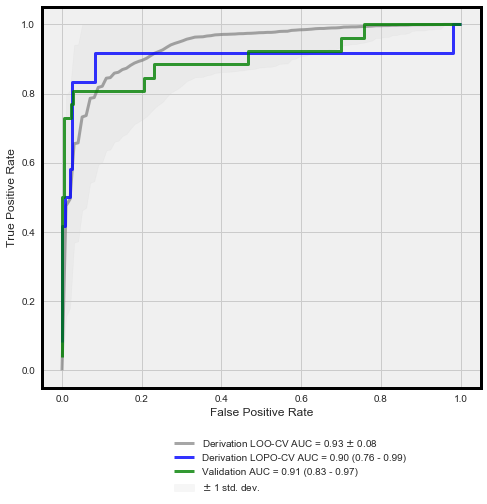


Number of 'Pathogens' in Training Set: 12
Number of 'Commensals' in Training Set: 155
Percentage of microbes used for training that are 'Pathogens': 0.0718562874251497

Number of 'Pathogens' in Test Set: 26
Number of 'Commensals'in Test Set: 174
Percentage of microbes used for TEST that are 'Pathogens': 0.0718562874251497


In [26]:
c = ['blue','red']

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
#ax.set_axis_bgcolor('white')
plt.rcParams['axes.facecolor'] = '#f0f0f0'

# 1000 rounds of 70%/30% train/test ROC Curve

mean_tpr_iterative = np.mean(tprs_iterative, axis=0)
mean_tpr_iterative[-1] = 1.0
mean_auc_iterative = auc(mean_fpr_iterative, mean_tpr_iterative)
std_auc_iterative = np.std(aucs_iterative)
plt.plot(mean_fpr_iterative, 
         mean_tpr_iterative, 
         color='grey',
         label=r'Derivation LOO-CV AUC = %0.2f $\pm$ %0.2f' % (mean_auc_iterative, 
                                                               std_auc_iterative),
         lw=3, alpha=.7)
std_tpr_iterative = np.std(tprs_iterative, axis=0)
tprs_iterative_upper = np.minimum(mean_tpr_iterative + std_tpr_iterative, 1)
tprs_iterative_lower = np.maximum(mean_tpr_iterative - std_tpr_iterative, 0)
plt.fill_between(mean_fpr_iterative, 
                 tprs_iterative_lower, 
                 tprs_iterative_upper, 
                 color='lightgrey', 
                 alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
xlim([-0.05, 1.05])
ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# LOPO-CV ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(list(X_g1g4_train['positive']),
                                         list(X_g1g4_train['score']), pos_label=1)    
ci = pathogen_functions.get_CI([int(i) for i in list(X_g1g4_train['positive'])], 
                               list(X_g1g4_train['score']), 1000)
plt.plot(fpr, tpr, 
         color='blue',
         lw=3, 
         alpha=.8, 
         label = 'Derivation LOPO-CV AUC = %0.2f (%0.2f - %0.2f)' % (metrics.roc_auc_score(
             list(X_g1g4_train['positive']),list(X_g1g4_train['score'])),ci[0],ci[1]))

# Test set ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(list(X_g1g4_test['positive']), 
                                         list(X_g1g4_test['score']), pos_label=1)    
ci = pathogen_functions.get_CI([int(i) for i in list(X_g1g4_test['positive'])], 
                               list(X_g1g4_test['score']), 1000)
plt.plot(fpr, tpr, 
         color='green',
         lw=3, 
         alpha=.8, 
         label = 'Validation AUC = %0.2f (%0.2f - %.2f)' % (metrics.roc_auc_score(
             list(X_g1g4_test['positive']),list(X_g1g4_test['score'])),ci[0],ci[1]))

# visual aspects of the plot
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
l = plt.legend(bbox_to_anchor=(.85, -.3),loc=4)
l.get_frame().set_facecolor('white')
l.get_frame().set_edgecolor('white')

plt.savefig('./output/' + output_directory + '/Figure2C.pdf', transparent = True,bbox_inches='tight')
plt.show()


# Return stats on the content of the Group 1 + Group 4 training set
print("\nNumber of \'Pathogens\' in Training Set: " + 
      str(Counter(list(X_combo['positive']))[True]))
print("Number of \'Commensals\' in Training Set: " + 
      str(Counter(list(X_combo['positive']))[False]))
print("Percentage of microbes used for training that are \'Pathogens\': " + 
      str(Counter(list(X_combo['positive']))[True]/X_combo.shape[0]))

print("\nNumber of \'Pathogens\' in Test Set: " + 
      str(Counter(list(X_g1g4_test['positive']))[True]))
print("Number of \'Commensals\'in Test Set: " + 
      str(Counter(list(X_g1g4_test['positive']))[False]))
print("Percentage of microbes used for TEST that are \'Pathogens\': " + 
      str(Counter(list(X_combo['positive']))[True]/X_combo.shape[0]))


#### Save microbe score results in .csv file for use in R script

In [27]:
# Compute MAX PATIENT SCORES for groups 2 and 3...
# this will be used as input to the R script for microbial arm of the combo score

for i in set(X_g1g4_test['patient']):
    patient_max_scores[i] = max(X_g1g4_test[X_g1g4_test['patient'] == i]['score'])

for i in set(X_g2['patient']):
    patient_max_scores[i] = max(X_g2[X_g2['patient'] == i]['score'])
    
for i in set(X_g3['patient']):
    patient_max_scores[i] = max(X_g3[X_g3['patient'] == i]['score'])
    
df = pd.DataFrame.from_dict(patient_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]

grp = []
for i in df.index:
    grp.append(int(metadata[metadata['RNAfilename']==i]['effective_group']))

df['color'] = grp

#write the scores to .csv file so they can be read as "microbe scores" into the R script
df.to_csv('./output/' + output_directory + '/patient_microbe_scores.csv')  

# write microbe predictions to .csv file 
patient_by_microbe_predicted_g1g4_test.to_csv('./output/' + 
                                              output_directory + 
                                              "/LRpred_G1G4_test.csv")
patient_by_microbe_predicted_g2.to_csv('./output/' + 
                                       output_directory + 
                                       '/LRpred_G2.csv')
patient_by_microbe_predicted_g3.to_csv('./output/' + 
                                       output_directory + 
                                       '/LRpred_G3.csv')

### Generate Supplemental Tables of Microbe Data (ie Table S3B)


In [28]:
X_withscores = pd.concat([X_g1g4_train,X_g1g4_test,X_g2,X_g3])
A = X_withscores[X_withscores['score'] > PROBABILITY_THRESHOLD].sort_values(by='patient')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 1]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                        output_directory + 
                                        '/group1POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 2]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group2POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 3]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group3POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 4]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group4POS.microbestats.csv')

In [29]:
X_withscores = pd.concat([X_g1g4_train,X_g1g4_test,X_g2,X_g3])

# add the clinical values    
X_withscores['Clin+'] = ['Y' if i else 'N' for i in list(X_withscores['positive'])]

# add one to ranks to make them more standard notation
X_withscores['ranks'] = X_withscores['ranks'] + 1

# append LRM predictions 
X_withscores['LRM+'] = ['Y' if i > PROBABILITY_THRESHOLD else 'N' for 
                        i in list(X_withscores['score'])]

# append the RBM predictions
all_RBM = pd.concat([rbm_g1,rbm_g2,rbm_g3,rbm_g4])
rbm_pos = []
for i in X_withscores.index:
    p = X_withscores.loc[i]['patient']
    m = X_withscores.loc[i]['microbe_genus']
    a = list(all_RBM[all_RBM['patient']==p]['microbe_genus'])
    if m in a:
        rbm_pos.append('Y')
    else:
        rbm_pos.append('N')
X_withscores['RBM+'] = rbm_pos    


X_withscores['Study ID'] = [i.split('-')[1] for i in list(X_withscores['patient'])]
X_withscores['keep'] = [list(X_withscores.loc[i][['Clin+','LRM+','RBM+']]).count('Y') > 0 for 
                        i in X_withscores.index]

lrti_cat_dict = {1:'LRTI+C/+M', 2:'LRTI+C',3:'unk-LRTI',4:'no-LRTI'}
X_withscores['LRTI Category'] = [lrti_cat_dict[i] for i in list(X_withscores['groupID'])]        
X_withscores.sort_values(by='Study ID',inplace=True)
X_withscores.head(n=10)

,RNAvalue,DNAvalue,nrnt,groupID,ranks,microbe,patient,microbe_genus,nt_Z_rna,nt_Z_dna,...,pathogenic_green,pathogenic_darkblue,positive,score,Clin+,LRM+,RBM+,Study ID,keep,LRTI Category
253,0.190332,0.017033,1,2,3,Sphingomonas wittichii ( 160791 ),mBAL-202-RNA-TA1-B10.report.csv,Sphingomonas ( 13687 ),-0.14,-0.14,...,False,True,False,0.001664,N,N,N,202,False,LRTI+C
252,0.795185,0.155336,1,2,2,Rhizopus microsporus ( 58291 ),mBAL-202-RNA-TA1-B10.report.csv,Rhizopus ( 4842 ),4.64,0.25,...,False,True,False,0.004152,N,N,N,202,False,LRTI+C
251,4.052482,0.000000,1,2,1,Rhinovirus A ( 147711 ),mBAL-202-RNA-TA1-B10.report.csv,Enterovirus ( 12059 ),99.00,0.00,...,True,False,False,0.374264,N,Y,Y,202,True,LRTI+C
88,2.896405,0.000000,1,1,1,Rhinovirus A ( 147711 ),mBAL-205-RNA-TA1-QIA-61917.report.csv,Enterovirus ( 12059 ),99.00,0.00,...,True,False,True,0.529262,Y,Y,Y,205,True,LRTI+C/+M
89,1.357935,0.000000,1,1,2,GB virus C ( 54290 ),mBAL-205-RNA-TA1-QIA-61917.report.csv,Pegivirus ( 1307799 ),100.00,0.00,...,True,False,False,0.009162,N,N,N,205,False,LRTI+C/+M
747,1.076276,1.216957,1,4,2,Streptococcus thermophilus ( 1308 ),mBAL-208-RNA-TA1-B10.report.csv,Streptococcus ( 1301 ),-0.18,-0.17,...,False,True,False,0.018359,N,N,N,208,False,no-LRTI
751,0.053078,0.262451,1,4,6,Bacillus cereus ( 1396 ),mBAL-208-RNA-TA1-B10.report.csv,Bacillus ( 1386 ),-0.53,-0.48,...,False,True,False,0.000119,N,N,N,208,False,no-LRTI
750,0.139879,0.294466,1,4,5,Lactobacillus sakei ( 1599 ),mBAL-208-RNA-TA1-B10.report.csv,Lactobacillus ( 1578 ),-0.32,-0.31,...,False,True,False,0.000336,N,N,N,208,False,no-LRTI
749,0.359835,0.525045,1,4,4,Staphylococcus aureus ( 1280 ),mBAL-208-RNA-TA1-B10.report.csv,Staphylococcus ( 1279 ),-0.26,-0.26,...,False,False,False,0.107210,N,N,N,208,False,no-LRTI
748,0.426511,0.056905,1,4,3,Pichia kluyveri ( 36015 ),mBAL-208-RNA-TA1-B10.report.csv,Pichia ( 4919 ),46.69,3.70,...,False,True,False,0.001557,N,N,N,208,False,no-LRTI


In [30]:
# This finalizes the output for TableS3B (Publication version)

table3B = X_withscores[X_withscores['keep']][['Study ID',
                                              'LRTI Category', 
                                              'microbe', 
                                              'Clin+', 
                                              'LRM+', 
                                              'RBM+',
                                              'RNAvalue',
                                              'DNAvalue',
                                              'ranks',
                                              'pathogenic_red',
                                              'pathogenic_green',
                                              'score',
                                              'nt_Z_rna',
                                              'nt_Z_dna']]

adding_to_df = []
for i in set(list(X_withscores['Study ID'])):
    if i not in list(table3B['Study ID']):
        adding_to_df.append(
            [i, str(list(X_withscores[X_withscores['Study ID']==i]['LRTI Category'])[0])] + 
            [None for i in range(12)])
        
df2 = pd.DataFrame(adding_to_df, columns=table3B.columns)
x = table3B.append(df2)
table3B = x

table3B.columns = ['Study ID',
                   'LRTI Category', 
                   'Microbe', 
                   'Clin+', 
                   'LRM+', 
                   'RBM+',
                   'log10( RNA-seq genus rpM )',
                   'log10( DNA-seq genus rpM )',
                   'Rank','Respiratory Pathogen?',
                   'Virus?',
                   'LRM Score',
                   'RNA Z-score',
                   'DNA Z-score']

table3B.sort_values(by=['Study ID','Rank'], inplace=True)
table3B_1 = table3B[table3B['LRTI Category'] == 'LRTI+C/+M']
table3B_2 = table3B[table3B['LRTI Category'] == 'LRTI+C']
table3B_3 = table3B[table3B['LRTI Category'] == 'unk-LRTI']
table3B_4 = table3B[table3B['LRTI Category'] == 'no-LRTI']

t3 = pd.concat([table3B_1,table3B_2,table3B_4,table3B_3])
t3.tail(n=10)
t3.to_csv('./output/' + output_directory + '/TableS3Bfinal.csv',index=False)

## Combining all methods of pathogen prediction

This is used to rapidly assess the microbial predictions, however it DID NOT end up in the manuscript due to the difficulty protraying the take-home message.

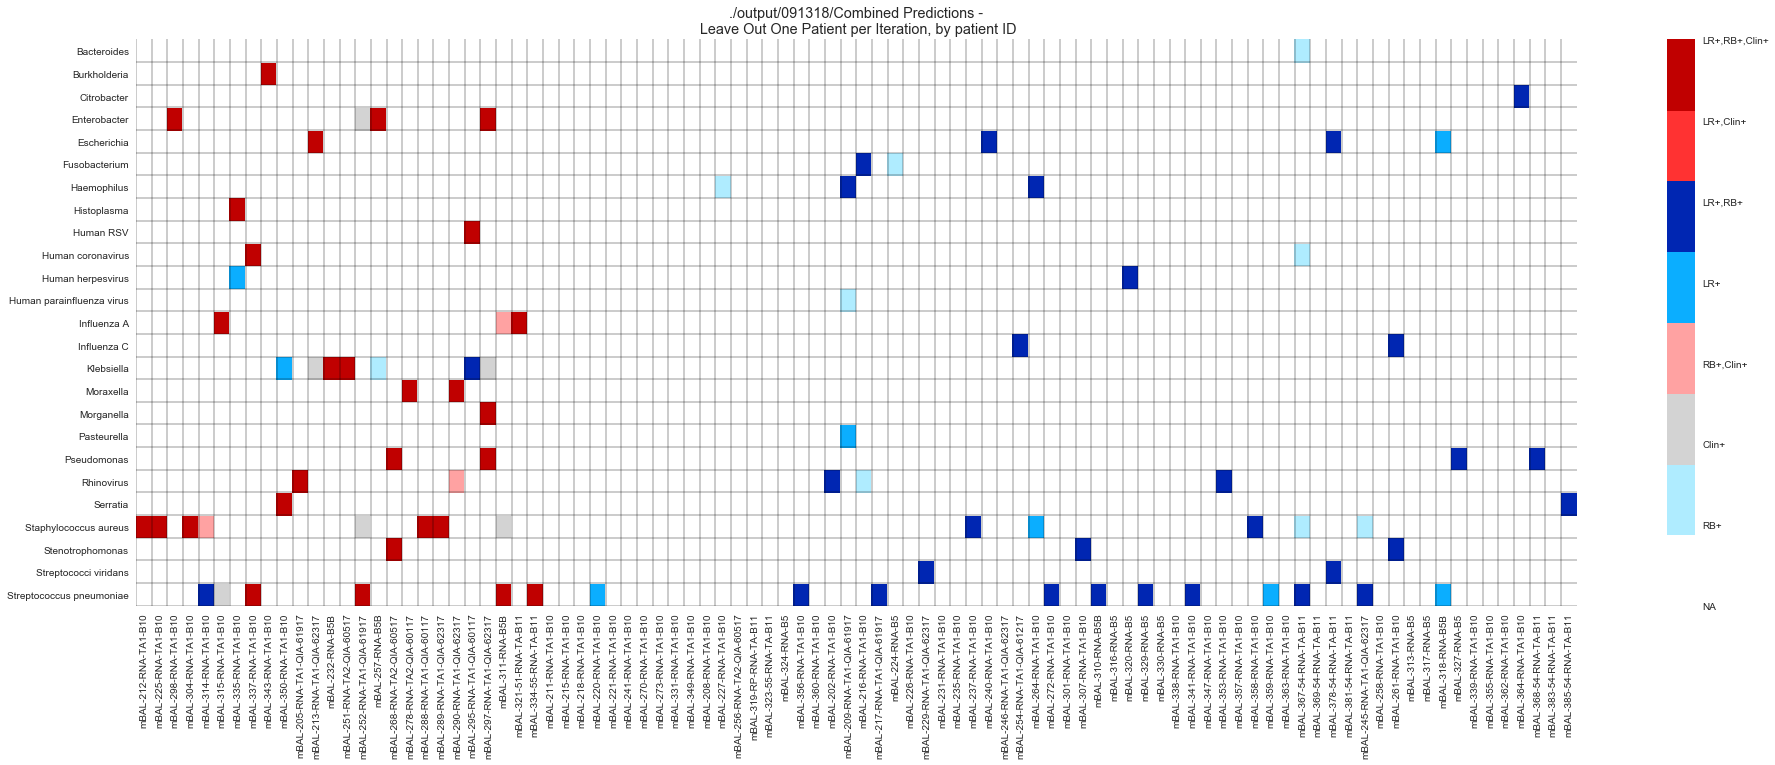

In [31]:
lr_results = pd.concat([patient_by_microbe_predicted_combo, 
                        patient_by_microbe_predicted_g1g4_test, 
                        patient_by_microbe_predicted_g2,
                        patient_by_microbe_predicted_g3]) #,patient_by_microbe_predicted_g4_test, 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])

# this representation enables easy viewing of the overlap btwn clinical and predicted results
# unfortunately, the published TableS2 does not highlight this aspect of the data as well, 
# so I am maintaining this graphic here.
d = plotting_functions.create_prediction_heatmap_combo_overlap(c,
                                                               lr_results,
                                                               X_full, 
                                                               './output/' + 
                                                               output_directory + 
                                                               '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                                               [1,4,2,3],
                                                               true_classification, 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest.pdf', 
                                                               print_output = False, 
                                                               collapse=True)

In [32]:
#Evaluate how many individuals had microbes identified by each method as compared to the known total number of group 1 patients.
print("Number of patients in Group 1 " + str(len(set(X_g1['patient']))))

print("\nNumber of patients in Group 1 w/ at least 1 pathogens identified by RBM " + 
      str(len(set(rbm_g1['patient']))))
print("Number of microbes identified by RBM in G1: "+ 
      str(len(rbm_g1['microbe'])))

print("\nNumber of patients in Group 1 w/ at least 1 pathogens identified by LR Model " + 
      str(len( set(X_g1['patient']).intersection(
          set(pd.concat([patient_by_microbe_predicted_combo,
                         patient_by_microbe_predicted_g1g4_test])['patient'])))))
print("Number of microbes identified by LR in both G1 and G4: "+ 
      str(len(pd.concat([patient_by_microbe_predicted_combo,
                         patient_by_microbe_predicted_g1g4_test])['microbe'])))

print("\nPatient IDs without a pathogen identified by RBM " + 
      str(set(X_g1['patient']) - set(rbm_g1['patient'])))
print("Patient IDs without a pathogen identified by LR Model " + 
      str(set(X_g1['patient']) - set(pd.concat([patient_by_microbe_predicted_combo,
                                                patient_by_microbe_predicted_g1g4_test])['patient'])))

Number of patients in Group 1 26

Number of patients in Group 1 w/ at least 1 pathogens identified by RBM 26
Number of microbes identified by RBM in G1: 35

Number of patients in Group 1 w/ at least 1 pathogens identified by LR Model 26
Number of microbes identified by LR in both G1 and G4: 35

Patient IDs without a pathogen identified by RBM set()
Patient IDs without a pathogen identified by LR Model set()


In [33]:
#Evaluate how many individuals had microbes identified by each method as compared to the known total number of group 1 patients.
print("Number of patients in Group 2 " + str(len(set(X_g2['patient']))))
print("\nNumber of patients in Group 2 w/ at least 1 pathogens identified by RBM " + 
      str(len(set(rbm_g2['patient']))))
print("Number of microbes identified by RBM: " + str(len(rbm_g2['patient'])))

print("\nNumber of patients in Group 2 w/ at least 1 pathogens identified by LR Model " + 
      str(len( set(X_g2['patient']).intersection(set(patient_by_microbe_predicted_g2['patient'])))))
print("Number of microbes identified by LR: " + str(len(patient_by_microbe_predicted_g2['patient'])))

print("\nPatient IDs without a pathogen identified by RBM:\n" + 
      '\n'.join(list(set(X_g2['patient']) - set(rbm_g2['patient']))))
print("\nPatient IDs without a pathogen identified by LR Model\n" + 
      '\n'.join(list(set(X_g2['patient']) - set(patient_by_microbe_predicted_g2['patient']))))

Number of patients in Group 2 34

Number of patients in Group 2 w/ at least 1 pathogens identified by RBM 20
Number of microbes identified by RBM: 26

Number of patients in Group 2 w/ at least 1 pathogens identified by LR Model 20
Number of microbes identified by LR: 23

Patient IDs without a pathogen identified by RBM:
mBAL-316-RNA-B5.report.csv
mBAL-369-54-RNA-TA-B11.report.csv
mBAL-359-RNA-TA1-B10.report.csv
mBAL-301-RNA-TA1-B10.report.csv
mBAL-231-RNA-TA1-B10.report.csv
mBAL-330-RNA-B5.report.csv
mBAL-357-RNA-TA1-B10.report.csv
mBAL-226-RNA-TA1-B10.report.csv
mBAL-246-RNA-TA1-QIA-62317.report.csv
mBAL-363-RNA-TA1-B10.report.csv
mBAL-235-RNA-TA1-B10.report.csv
mBAL-381-54-RNA-TA-B11.report.csv
mBAL-347-RNA-TA1-B10.report.csv
mBAL-338-RNA-TA1-B10.report.csv

Patient IDs without a pathogen identified by LR Model
mBAL-316-RNA-B5.report.csv
mBAL-369-54-RNA-TA-B11.report.csv
mBAL-301-RNA-TA1-B10.report.csv
mBAL-231-RNA-TA1-B10.report.csv
mBAL-330-RNA-B5.report.csv
mBAL-224-RNA-B5.report.

In [34]:
#OUTPUT per-patient microbe predictions to files
rbm_g1.to_csv('./output/' + output_directory + '/rbm_g1.csv')
rbm_g2.to_csv('./output/' + output_directory + '/rbm_g2.csv')
rbm_g3.to_csv('./output/' + output_directory + '/rbm_g3.csv')
rbm_g4.to_csv('./output/' + output_directory + '/rbm_g4.csv')

patient_by_microbe_predicted_combo.to_csv('./output/' + 
                                          output_directory + 
                                          '/patient_by_microbe_predicted_combo.csv')
patient_by_microbe_predicted_g2.to_csv('./output/' + 
                                       output_directory + 
                                       '/patient_by_microbe_predicted_g2.csv')
patient_by_microbe_predicted_g3.to_csv('./output/' + 
                                       output_directory + 
                                       '/patient_by_microbe_predicted_g3.csv')

In [35]:
# write the full training and test data matrices to a .csv file so other individuals could replicate the models
X_combo.to_csv("./output/" + output_directory + '/LRTrainingData.csv')
X_g1g4_test.to_csv("./output/" + output_directory + '/LRTestData.csv')

## Outstanding Qs and Supplemental Figures

**FIGURE S2: Create a 2-part heatmap where part 1 = clinical only, part 2 = RBM/LRM resutls; divided up by sub-component (LRTI+C/+M Deriviation / LRTI+C/+M Validation / no-LRTI Derivation / no-LRTI Validation / LRTI+C / unk-LRTI)**

<Figure size 162x468 with 0 Axes>

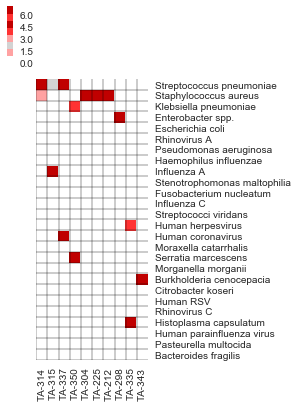

<Figure size 162x468 with 0 Axes>

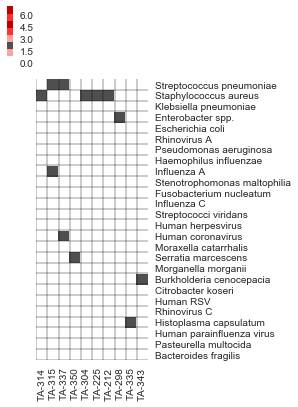

<Figure size 259.2x468 with 0 Axes>

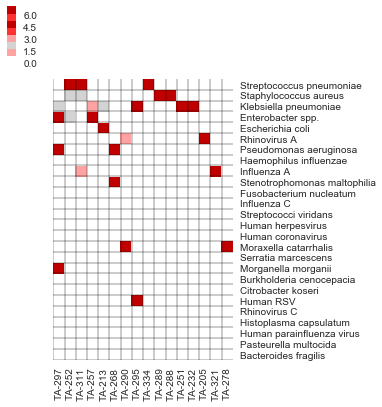

<Figure size 259.2x468 with 0 Axes>

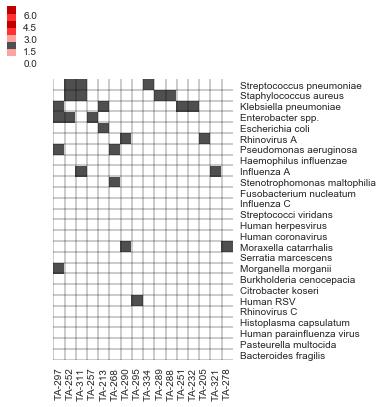

<Figure size 162x468 with 0 Axes>

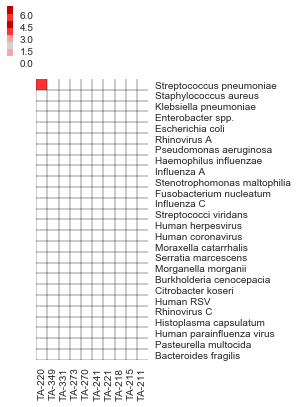

<Figure size 162x468 with 0 Axes>

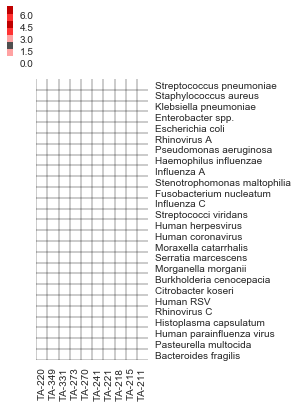

<Figure size 129.6x468 with 0 Axes>

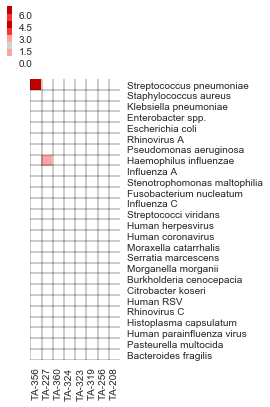

<Figure size 129.6x468 with 0 Axes>

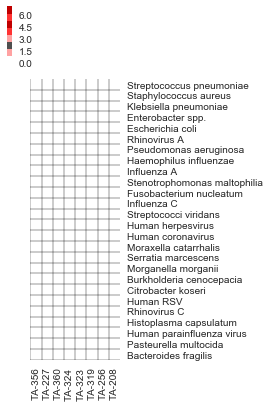

<Figure size 550.8x468 with 0 Axes>

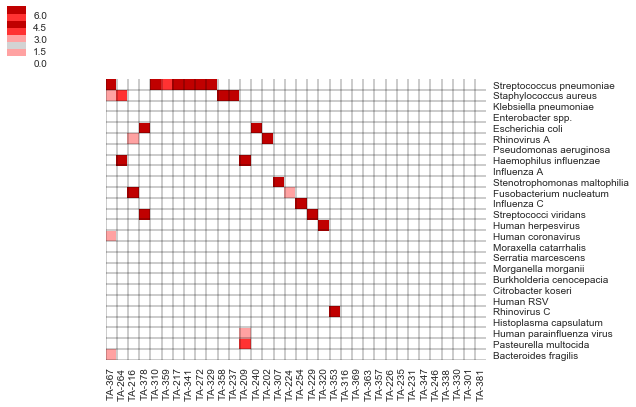

<Figure size 550.8x468 with 0 Axes>

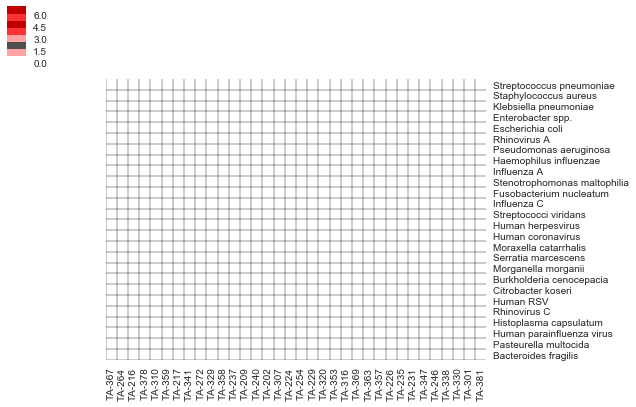

<Figure size 226.8x468 with 0 Axes>

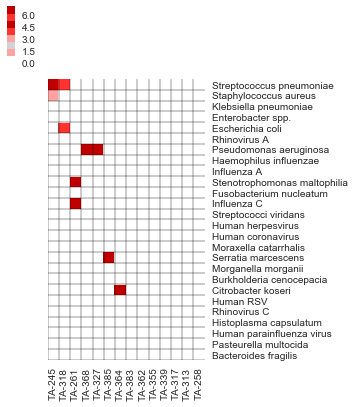

<Figure size 226.8x468 with 0 Axes>

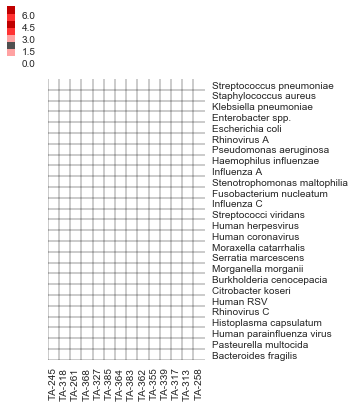

In [36]:
lr_results = pd.concat([patient_by_microbe_predicted_combo, patient_by_microbe_predicted_g1g4_test, patient_by_microbe_predicted_g2,patient_by_microbe_predicted_g3]) 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])
d = plotting_functions.create_prediction_heatmap_combo_overlap_update2(c,
                                 lr_results,
                                 X_full, 
                                 './output/' + 
                                 output_directory + 
                                 '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                 [1,4,2,3],
                                 true_classification, 
                                 output_directory,
                                 metadata, 
                                 training_sample_names,
                                 'FigureS3_TrainTest.pdf',
                                 print_output = False, collapse=True)

**For comparison, create a scatterplot for the water samples!**

Note, the axes of this scatterplot are from 0 to .8. All other scatterplots (ie Figure S1) are on the axis 0 - 5. This emphasizes the fact that water samples had substantially fewer microbial reads. 

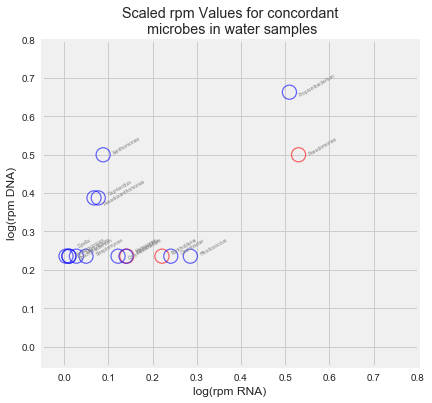

In [38]:
dna_water = pd.read_csv('data/' + data_directory + '/water_controls/' + 
                        'direct_water_subtraction_DNA.concordant.csv',index_col=0)
rna_water = pd.read_csv('data/' + data_directory + '/water_controls/' + 
                        'direct_water_subtraction_RNA.concordant.csv',index_col=0)

c = ['blue','red']
water_pathogens = [c[int(i.split(' ')[0] in ' '.join(full_respiratory_microbes_list))] for 
                   i in dna_water.index]

plt.figure(figsize=(6, 6))
plt.scatter(np.log10(rna_water['x']+1),  
                           np.log10(dna_water['x']+1),               
            alpha = .6,
            marker='o',
            s=200,
            edgecolor=water_pathogens, 
            facecolor='none', 
            linewidth = 1.2 )

plt.xlim((-.05, 0.8))
plt.ylim((-.05, 0.8))

# annotate the scatterplot points with the microbe name
for n in dna_water.index:
    plt.annotate(n.split(' ')[0], (np.log10(rna_water.loc[n]['x']+1)+.02,  
                               np.log10(dna_water.loc[n]['x']+1)+.04),
                                             fontsize=5, color='grey',rotation=30) 
    
plt.xlabel("log(rpm RNA)")
plt.ylabel("log(rpm DNA)")
plt.title("Scaled rpm Values for concordant\n microbes in water samples")
plt.savefig('./output/' + output_directory + '/Water_Microbes.pdf')

**Are there any LR predictions that weren't in the list of common respiratory pathogens?**

While the LR model does potentially enable the detection of "putative pathogens" that are not in the list of known respiratory pathogens, there were few cases of this in our cohort. 

In [39]:
# merge all the relevant dataframes of predictions
not_in_list_of_common = pd.concat([X_combo, X_g1g4_test, X_g2, X_g3])  

# report the predictions that were positive by LRM and not in the list of common pathogens (ie pathogenic_red != True)
not_in_list_of_common[not_in_list_of_common['score'] > PROBABILITY_THRESHOLD][not_in_list_of_common[not_in_list_of_common['score'] > PROBABILITY_THRESHOLD]['pathogenic_red'] == False]

,RNAvalue,DNAvalue,nrnt,groupID,ranks,microbe,patient,microbe_genus,nt_Z_rna,nt_Z_dna,pathogenic_red,pathogenic_green,pathogenic_darkblue,positive,score
46,2.568425,2.593718,1,1,0,Human herpesvirus 1 ( 10298 ),mBAL-335-RNA-TA1-B10.report.csv,Simplexvirus ( 10294 ),99.00,99.00,False,True,False,False,0.878395
588,2.840489,3.456613,1,3,0,Streptococcus parasanguinis ( 1318 ),mBAL-318-RNA-B5B.report.csv,Streptococcus ( 1301 ),0.25,1.59,False,False,True,False,0.396355


**What is the sensitivity and specificity of the RBM and LRM (on the microbe level)**

In [40]:
# SENSITIVITY AND SPECIFICITY CALCULATIONS -- 3/22

# RBM Performance - combined the derivation and validation sets to report only 
# the overall sens/spec.
print("RBM Overall Performance (for G1 and G4, regardless of Training v. Test Set)")
Xws = X_withscores[X_withscores['LRTI Category'].isin(['LRTI+C/+M','no-LRTI'])]
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws['Clin+'])],
                                  [i == 'Y' for i in list(Xws['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

#a = Xws[Xws['RBM+']=="Y"]
#b = a[a['Clin+']=="N"]
#print(b)




print("\n------------\n")

# PERFOMANCE SEPARATED BY TRAINGING AND TEST SETS
Xws_train = X_withscores[X_withscores['patient'].isin(list(X_g1g4_train['patient']))]
print("Training set size:")
print(Xws_train.shape)
print("Test set size:")
Xws_test = X_withscores[X_withscores['patient'].isin(list(X_g1g4_test['patient']))]
print(Xws_test.shape)

print("\n------------\n")

# RBM Performance - combined the derivation and validation sets to report only 
# the overall sens/spec.
print("RBM training performance")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_train['Clin+'])],
                                  [i == 'Y' for i in list(Xws_train['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))
print("\n")

print("RBM test performance")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_test['Clin+'])],
                                  [i == 'Y' for i in list(Xws_test['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\n------------\n")

# LRM Performance, separated by training and test set
print("\nLRM training performance:")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_train['Clin+'])],
                                  [i == 'Y' for i in list(Xws_train['LRM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\nLRM test performance:")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_test['Clin+'])],
                                  [i == 'Y' for i in list(Xws_test['LRM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\nNote: PROBABILITY_THRESHOLD used = " + str(PROBABILITY_THRESHOLD))

RBM Overall Performance (for G1 and G4, regardless of Training v. Test Set)
TN : TP : FP : FN = [324, 32, 5, 6]
Sensitivity: 0.8421052631578947
Specificity: 0.9848024316109423
Accuracy:0.9700272479564033

------------

Training set size:
(167, 21)
Test set size:
(200, 21)

------------

RBM training performance
TN : TP : FP : FN = [154, 11, 1, 1]
Sensitivity: 0.9166666666666666
Specificity: 0.9935483870967742
Accuracy:0.9880239520958084


RBM test performance
TN : TP : FP : FN = [170, 21, 4, 5]
Sensitivity: 0.8076923076923077
Specificity: 0.9770114942528736
Accuracy:0.955

------------


LRM training performance:
TN : TP : FP : FN = [151, 10, 4, 2]
Sensitivity: 0.8333333333333334
Specificity: 0.9741935483870968
Accuracy:0.9640718562874252

LRM test performance:
TN : TP : FP : FN = [172, 19, 2, 7]
Sensitivity: 0.7307692307692307
Specificity: 0.9885057471264368
Accuracy:0.955

Note: PROBABILITY_THRESHOLD used = 0.36


#### Proving to myself that the LRM is better than just RNA+DNA rpm


original number of total microbes: (200, 16)
number of microbes after removing polymicrobial: (190, 16)


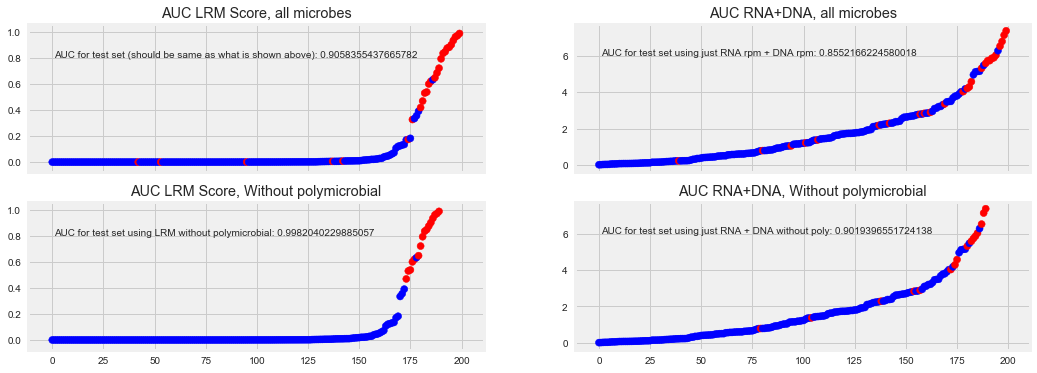

In [41]:
# set up 4-panel scatter plot
fig, axarr = plt.subplots(2,2, figsize=(16,6), sharey = False, sharex = True)  

# AUC for LRM on test set
# in scatterplot, we should ideally see all blue dots (commensals) with low scores 
# and all red dots (pathogens) with high scores
t = X_g1g4_test
t.sort_values(by='score', inplace=True)
#plt.figure(figsize=(8,3))
axarr[0,0].scatter([i for i in range(len(t.index))], t['score'], color = 
                   ['red' if t.loc[i]['positive'] else 'blue' for i in t.index])
axarr[0,0].annotate("AUC for test set (should be same as what is shown above): " + 
                    str(metrics.roc_auc_score(list(X_g1g4_test['positive']),
                                              list(X_g1g4_test['score']))),
                    xy=(1,.8))
axarr[0,0].set_title('AUC LRM Score, all microbes')
#plt.show()

# AUC for RNA rpm + DNA rpm on test set
# in scatterplot, we should ideally see all blue dots (commensals) with low scores 
# and all red dots (pathogens) with high scores
t['RNA+DNA'] = list(X_g1g4_test['RNAvalue']+X_g1g4_test['DNAvalue'])
t1 = t
t.sort_values(by='RNA+DNA', inplace=True)
axarr[0,1].scatter([i for i in range(len(t.index))], t['RNA+DNA'], 
                   color = ['red' if t.loc[i]['positive'] else 'blue' for i in t.index])
axarr[0,1].annotate("\nAUC for test set using just RNA rpm + DNA rpm: " + 
                    str(metrics.roc_auc_score(list(X_g1g4_test['positive']),
                                              list(X_g1g4_test['RNAvalue']+
                                                   X_g1g4_test['DNAvalue']))),
                    xy=(1,6))
axarr[0,1].set_title('AUC RNA+DNA, all microbes')

# remove all additional microbes (only 1 etiologic pathogen per person)
tpos = t[t['positive']]
tneg = t[t['positive']==False]
t2 = tpos.drop_duplicates(subset=['patient','positive'], keep="last")
t3 = pd.concat([t2,tneg])

# print the change in microbe numbers
print("\noriginal number of total microbes: " + str(t.shape))
print("number of microbes after removing polymicrobial: " + str(t3.shape))

# AUC for LRM Score on test set with only 1 microbe / person
t3.sort_values(by='score',inplace=True)
axarr[1,0].scatter([i for i in range(len(t3.index))], t3['score'], 
                   color = ['red' if t3.loc[i]['positive'] else 'blue' for i in t3.index])
axarr[1,0].annotate("\nAUC for test set using LRM without polymicrobial: "+ 
                    str(metrics.roc_auc_score(list(t3['positive']),list(t3['score']))),
                    xy=(1,.8))
axarr[1,0].set_title('AUC LRM Score, Without polymicrobial')

# AUC for RNA+DNA on test set with only 1 microbe / person
t3.sort_values(by='RNA+DNA',inplace=True)
axarr[1,1].scatter([i for i in range(len(t3.index))], t3['RNA+DNA'], 
                   color = ['red' if t3.loc[i]['positive'] else 'blue' for i in t3.index])
axarr[1,1].annotate("\nAUC for test set using just RNA + DNA without poly: " + 
                    str(metrics.roc_auc_score(list(t3['positive']),
                                              list(t3['RNAvalue']+t3['DNAvalue']))),
                    xy=(1,6))
axarr[1,1].set_title('AUC RNA+DNA, Without polymicrobial')
plt.show()

### Learning Curve Analysis

Is the training set an appropriate size for the logistic regression model?

> "To evaluate the logistic regression model performance as a function of derivation cohort size, learning curves were computed using randomized subsets of microbes from the derivation set (n = 5, 10, 15…165 total training microbes). The training and test mean square error (MSE) were computed along with the AUC for the test set at each iteration. This process was repeated over 25 rounds and the mean learning curve was computed (Figure S5A). The results indicate that the training set has saturated model performance, suggesting adequate sample size for the aforementioned analyses. We note that balanced classes may be of benefit, but are unrealistic given the distribution of pathogens amongst the lung microbiome."

STARTING NEW LC ITERATION: 0
STARTING NEW LC ITERATION: 1
STARTING NEW LC ITERATION: 2
STARTING NEW LC ITERATION: 3
STARTING NEW LC ITERATION: 4
STARTING NEW LC ITERATION: 5
STARTING NEW LC ITERATION: 6
STARTING NEW LC ITERATION: 7
STARTING NEW LC ITERATION: 8
STARTING NEW LC ITERATION: 9
STARTING NEW LC ITERATION: 10
STARTING NEW LC ITERATION: 11
STARTING NEW LC ITERATION: 12
STARTING NEW LC ITERATION: 13
STARTING NEW LC ITERATION: 14
STARTING NEW LC ITERATION: 15
STARTING NEW LC ITERATION: 16
STARTING NEW LC ITERATION: 17
STARTING NEW LC ITERATION: 18
STARTING NEW LC ITERATION: 19
STARTING NEW LC ITERATION: 20
STARTING NEW LC ITERATION: 21
STARTING NEW LC ITERATION: 22
STARTING NEW LC ITERATION: 23
STARTING NEW LC ITERATION: 24
complete


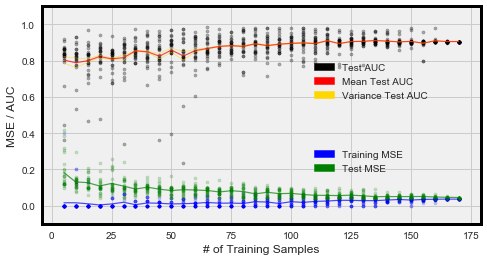

In [42]:
from sklearn.model_selection import LeaveOneOut
from operator import itemgetter

#
# Generate learning curve and associated performance metrics; save to dataframe 
# for subsequent plotting.
#

# this takes some time, so set False if we don't want this portion of analysis to run.
run_LC = True  

if run_LC:
    
    # Generate the data for the learning curves
    X_combo = pd.concat([X_g1_train,X_g4_train])  # train on both group 1 and group 4 patients
    y_combo = Y_g1_train + Y_g4_train

    # track num iterations w/ only one class present (likely the negative class) in the test set
    oneclasspresent = 0  
    c = ['blue','red']  

    # set variables to track performance across iterations
    full_aucs = {}
    full_accs = {}
    full_patient_aucs = {}
    full_acc_train = {}
    full_auc_train = {}
    full_trainE = {}
    full_testE = {}
    full_trainppE = {}
    full_testppE = {}

    for n_iters in range(25):    # run the full learning curve 25 times, to estimate variance
        print("STARTING NEW LC ITERATION: " + str(n_iters))                  # "progress bar"
        
        # set variables to track performance within each iteration
        aucs_iterative = []
        acc = []
        sens = []
        spec = []
        acc_train = []
        patient_aucs = []
        aucs_iterative_train = []
        trainE = []
        testE = []
        trainppE = []
        testppE = []

        # loop from 1 to 170, to randomly select n*5 = 5 - 170 training samples to use for 
        # the training as this value increases, the performance is expected to improve 
        # and eventually plateau
        for i in range(34):  

            # at lower numbers you may have only 1 class represented (imbalanced classes), 
            # so repeat until you randomly draw... 
            unsuccessful = True            
            
            # ...a set including at least 1 training sample from both "pathogen" and 
            # "commensal" classes
            while unsuccessful == True:    

                try:   # try to randomly select n*5 training samples
                    r = random.sample([j for j in range(len(X_combo.index))], (i+1)*5)     
                except: # if you have exceeded the max number of samples, use all training data
                    r = [j for j in range(len(X_combo.index))]
                
                # create the sub-training set based on sampled indices
                X_train = X_combo.iloc[r][training_variables] 
                y_train = itemgetter(*r)(y_combo)

                X_test = X_g1g4_test[training_variables] # test set is full test set
                y_test = X_g1g4_test['positive']

                # keep looping until you have a success
                if True:
                    try:
                        
                        # create logistic regression model; no regularization
                        lr = linear_model.LogisticRegression(C=1000000) 
                        lr.fit(X_train, y_train)    # fit the logistic regression model

                        # compute training error metrics
                        cm_train = confusion_matrix(y_train, 
                                                    lr.predict(X_train) > PROBABILITY_THRESHOLD)
                        train_predict = lr.predict_proba(X_train)[:,1] > PROBABILITY_THRESHOLD
                        train_error =  sum([(train_predict[j] - int(y_train[j]))**2 for 
                                            j in range(len(y_train))])/len(y_train)
                        trainE.append(train_error)
                        total_train=sum(sum(cm_train))
                        accuracy_train=(cm_train[0,0]+cm_train[1,1])/total_train
                        acc_train.append(accuracy_train)
                        fpr, tpr, thresholds = metrics.roc_curve(y_train, 
                                                                 lr.predict_proba(X_train)[:,1], 
                                                                 pos_label=1)  
                        aucs_iterative_train.append(auc(fpr, tpr))

                        # compute test error metrics
                        test_predict = lr.predict_proba(X_test)[:,1] > PROBABILITY_THRESHOLD
                        test_error =  sum([(test_predict[j] - int(list(y_test)[j]))**2 for 
                                           j in range(len(y_test))])/len(y_test)
                        testE.append(test_error)
                        cm1 = confusion_matrix(y_test, lr.predict(X_test) > PROBABILITY_THRESHOLD)
                        total1=sum(sum(cm1))
                        accuracy1=(cm1[0,0]+cm1[1,1])/total1
                        acc.append(accuracy1)
                        sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
                        sens.append(sensitivity1)
                        specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) 
                        spec.append(specificity1)

                        fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                                                 lr.predict_proba(X_test)[:,1], 
                                                                 pos_label=1)  
                        tprs_iterative.append(interp(mean_fpr_iterative, fpr, tpr))
                        tprs_iterative[-1][0] = 0.0
                        roc_auc = auc(fpr, tpr)
                        aucs_iterative.append(roc_auc)


                        # get the maximum score per patient, use this to calculate AUC for LRTI v. No LRTI prediction
                        X_test_pp = X_g1g4_test
                        X_test_pp['score'] = lr.predict_proba(X_test)[:,1]
                        idx = X_test_pp.groupby(['patient'])['score'].transform(max) == X_test_pp['score'] 
                        X_test_pp2 = X_test_pp[idx] 
                        fpr, tpr, thresholds = metrics.roc_curve(X_test_pp2['groupID']==1, X_test_pp2['score'], pos_label=1) 
                        patient_aucs.append(auc(fpr, tpr))
                        test_pp_error =  sum([(X_test_pp2.iloc[j]['score'] - int(X_test_pp2.iloc[j]['groupID']==1))**2 for 
                                              j in range(len(X_test_pp2.index))])/len(X_test_pp2.index)
                        testppE.append(test_pp_error)

                        X_train_pp = X_combo.iloc[r]
                        X_train_pp['score'] = lr.predict_proba(X_train)[:,1]
                        idx = X_train_pp.groupby(['patient'])['score'].transform(max) == X_train_pp['score'] 
                        X_train_pp2 = X_train_pp[idx] 
                        train_pp_error =  sum([(X_train_pp2.iloc[j]['score'] - int(X_train_pp2.iloc[j]['groupID']==1))**2 for 
                                               j in range(len(X_train_pp2.index))])/len(X_train_pp2.index)
                        trainppE.append(train_pp_error)
                        
                        
                        unsuccessful = False   # successfully reached the end of this iteration of learning curve, so break out of while loop

                    except Exception as e:
                        oneclasspresent += 1

        # the full learning curve is complete, 
        # add performance metrics for this round (will run many times) to the final output
        full_aucs[n_iters] = aucs_iterative
        full_accs[n_iters] = acc
        full_patient_aucs[n_iters] = patient_aucs
        full_acc_train[n_iters] = acc_train
        full_auc_train[n_iters] = aucs_iterative_train
        full_trainE[n_iters] = trainE
        full_testE[n_iters] = testE
        full_trainppE[n_iters] = trainppE
        full_testppE[n_iters] = testppE


    # create a dataframe of the AUC for each round of learning curve at each set of n training samples
    df = pd.DataFrame(full_aucs)
    df2 = pd.DataFrame(full_accs)
    df3 = pd.DataFrame(full_patient_aucs)
    df4 = pd.DataFrame(full_acc_train)
    df5 = pd.DataFrame(full_auc_train)

    df6 = pd.DataFrame(full_trainE)
    df7 = pd.DataFrame(full_testE)
    df8 = pd.DataFrame(full_trainppE)
    df9 = pd.DataFrame(full_testppE)

    print("complete")

    df5.tail(n=10)

#
# PLOT the learning curve plot used in the publication Figure S5
#

if run_LC:

    # set up the legend
    blue_patch = mpatches.Patch(color='blue', label='Training MSE')
    green_patch = mpatches.Patch(color='green', label='Test MSE')
    black_patch = mpatches.Patch(color='black', label='Test AUC')
    red_patch = mpatches.Patch(color='red', label='Mean Test AUC')
    yellow_patch = mpatches.Patch(color='gold', label='Variance Test AUC')

    # for the microbe v. pathogen model
    fig, ax = plt.subplots(figsize=[7,4], facecolor='white')
    #ax.set_axis_bgcolor('white')
    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df6.loc[i]))], df6.loc[i], 
                    alpha=.2,color='blue',s=10)
    plt.plot([(i+1)*5 for i in range(len(df6.index))],df6.transpose().mean(),
             alpha = .7, lw = 1.2, color='blue') # training
    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df7.loc[i]))], df7.loc[i], 
                    alpha=.2,color='green',s=10)
    plt.plot([(i+1)*5 for i in range(len(df7.index))],df7.transpose().mean(),
             alpha = .7, lw = 1.2, color='green') #test

    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df.loc[i]))], df.loc[i], 
                    alpha=.3,s=10,color="black")
    plt.plot([(i+1)*5 for i in range(len(df.index))], 
             df.transpose().mean() - df.transpose().var(), alpha = .7, lw = .6, color="gold")
    plt.plot([(i+1)*5 for i in range(len(df.index))], 
             df.transpose().mean() + df.transpose().var(), alpha = .7, lw = .6, color="gold")
    plt.plot([(i+1)*5 for i in range(len(df.index))],
             df.transpose().mean(),alpha = .7, lw = 1.2, color="red")

    plt.xlabel('# of Training Samples')
    plt.ylabel('MSE / AUC')
    plt.ylim([-.1,1.1])
    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('0')
    ax.spines['right'].set_color('0')
    ax.spines['left'].set_color('0')
    first_legend = plt.legend(handles=[black_patch, red_patch, yellow_patch], 
                              bbox_to_anchor=(.6,0.78),loc=2)
    a = plt.gca().add_artist(first_legend)
    a.get_frame().set_facecolor('white')
    a.get_frame().set_edgecolor('white')
    l = plt.legend(handles=[blue_patch, green_patch],bbox_to_anchor=(.6,0.38),loc=2)
    l.get_frame().set_facecolor('white')
    l.get_frame().set_edgecolor('white')
    plt.savefig('./output/' + output_directory + '/FigureS5A.pdf',transparent=True)
    plt.show()

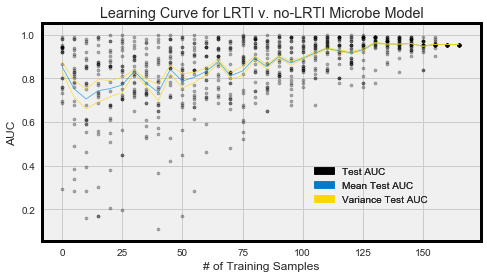

In [43]:
# This plots the "learning curve" for using the top pathogen probability score per 
# patient to distinguish between LRTI and no-LRTI groups
# currently not included in the manuscript, but conclusion is the same as above: 
# we are approaching the required number...
# ...of samples foraccurate estimation of the AUC

# NOT INCLUDED IN MANUSCRIPT due to second-order measurement effect

m = []
v = []

fig, ax = plt.subplots(figsize=[7,4], facecolor='white')
#ax.set_axis_bgcolor('white')
for i in range(len(df3.index)):
    m.append(np.mean(df3.iloc[i]))
    v.append(np.var(df3.iloc[i]))
    plt.scatter([i*5 for j in range(len(df3.iloc[i]))], df3.iloc[i], color='black', alpha=.3, s=10)
plt.plot([i*5 for i in range(len(m))], m,alpha = .7, lw = .8)
plt.plot([i*5 for i in range(len(m))], [m[i]+v[i] for i in range(len(v))],
         alpha = .7, lw = .8, color='gold')
plt.plot([i*5 for i in range(len(m))], [m[i]-v[i] for i in range(len(v))],
         alpha = .7, lw = .8, color='gold')

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')

black_patch = mpatches.Patch(color='black', label='Test AUC')
blue_patch = mpatches.Patch(color='#007acc', label='Mean Test AUC')
yellow_patch = mpatches.Patch(color='gold', label='Variance Test AUC')
first_legend = plt.legend(handles=[black_patch, blue_patch, yellow_patch],
                          bbox_to_anchor=(.6,0.38),loc=2)
a = plt.gca().add_artist(first_legend)
a.get_frame().set_facecolor('white')
a.get_frame().set_edgecolor('white')


plt.xlabel('# of Training Samples')
plt.ylabel('AUC')
plt.title("Learning Curve for LRTI v. no-LRTI Microbe Model")
plt.savefig('./output/' + output_directory + '/FigureS5A_microbe.pdf',transparent=True)
plt.show()